# MLP para Classificação - Dataset: Iris

O conjunto de dados Iris é um dos datasets mais conhecidos e amplamente utilizados no mundo da aprendizagem de máquina e da estatística. Introduzido pelo biólogo e estatístico britânico Ronald A. Fisher em 1936, o dataset é composto por 150 observações de três espécies de flores iris: setosa, versicolor e virginica.

Cada observação contém quatro características (ou atributos) mensuráveis das flores: comprimento e largura das sépalas, e comprimento e largura das pétalas, todos medidos em centímetros. O objetivo principal associado a este conjunto de dados é o problema de classificação: com base nas medidas das sépalas e pétalas, pretende-se determinar a espécie da flor. 

Devido à sua simplicidade e clareza, o dataset Iris tornou-se um padrão para testar técnicas de classificação e análise de padrões, servindo como um ponto de partida ideal para iniciantes na área de aprendizado de máquina.

## Importar bibliotecas e carregar o dataset:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

# Carregando o dataset Iris
iris = datasets.load_iris()
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target

# Mostrando as primeiras linhas
df_iris


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     species  
0          0  
1          0  
2          0  
3          0  
4          0  
..       ...  
145        2  
146        2  
147        2  
148        2  
149        2  

[150 rows x 5 columns]

## Visualização inicial dos dados:

C:\Users\ealbvit\AppData\Local\anaconda3\envs\redes_neurais\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


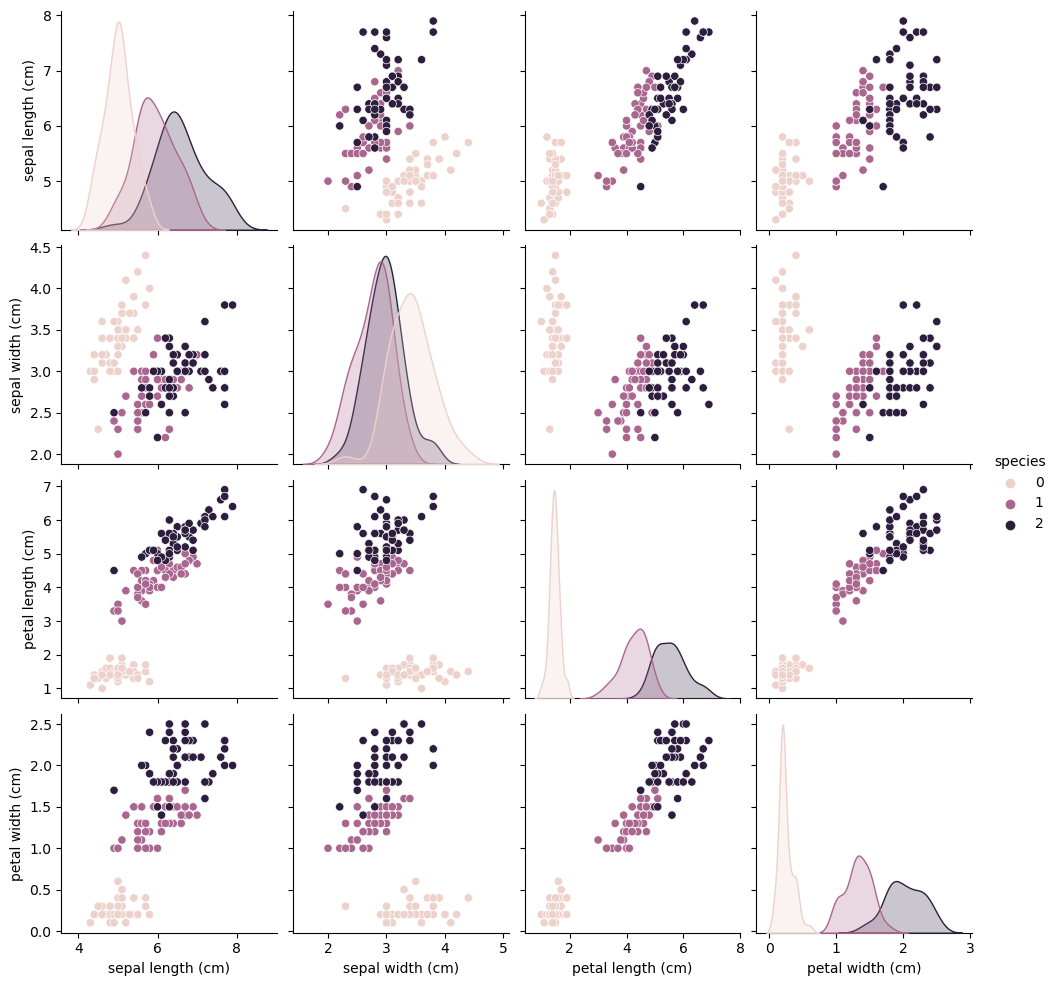

In [2]:
# Pairplot para visualizar as distribuições e relações entre os atributos
sns.pairplot(df_iris, hue='species')
plt.show()

#### Construção da MLP

## Pré-processamento dos Dados - Dataset Iris
### Divisão dos Dados:
Vamos começar dividindo o dataset em conjuntos de treino, validação e teste. Isso nos permitirá treinar nosso modelo no conjunto de treino, ajustar hiperparâmetros usando o conjunto de validação e, finalmente, avaliar o desempenho no conjunto de teste.


In [3]:
from sklearn.model_selection import train_test_split

X = df_iris.drop(columns=['species'])
y = df_iris['species']

# Dividindo em treino e teste (80% treino, 20% teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividindo o conjunto temporário em validação e teste (metade para cada)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


### Normalização:

Vamos usar o StandardScaler do scikit-learn para isso. Ele normaliza os dados para terem média 0 e desvio padrão 1.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Ajustando o scaler apenas nos dados de treino
scaler.fit(X_train)

# Aplicando o scaler nos conjuntos de treino, validação e teste
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


### One-Hot Encoding:
Como estamos lidando com um problema de classificação multiclasse, é benéfico transformar nossas etiquetas (labels) categóricas em uma representação "one-hot". Isso significa que, em vez de uma única coluna com valores 0, 1 ou 2, teremos três colunas, cada uma representando uma classe.
Por exemplo, a classe 0 (setosa) pode ser representada como [1, 0, 0], a classe 1 (versicolor) como [0, 1, 0], e a classe 2 (virginica) como [0, 0, 1].

Vamos usar o OneHotEncoder do scikit-learn para fazer isso:

In [5]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

# Ajustando e transformando as etiquetas do conjunto de treino
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))


### Criando a Rede MLP

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2

# Definindo uma função para criar a MLP com base na topologia e arquitetura
def build_mlp(topology, architecture):
    model = Sequential()
    input_dim = X_train_scaled.shape[1]
    
    # Adicionando a camada de entrada e camadas ocultas
    first_layer = True
    for neurons in topology:
        if first_layer:
            if "Regularização" in architecture:
                model.add(Dense(neurons, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)))
            else:
                model.add(Dense(neurons, activation='relu', input_dim=input_dim))
            first_layer = False
        else:
            if "Regularização" in architecture:
                model.add(Dense(neurons, activation='relu', kernel_regularizer=l2(0.01)))
            else:
                model.add(Dense(neurons, activation='relu'))
    
    # Adicionando a camada de saída
    model.add(Dense(3, activation='softmax'))
    
    # Definindo o otimizador
    if "Momentum" in architecture:
        optimizer = SGD(learning_rate=0.01, momentum=0.9)
    else:
        optimizer = SGD(learning_rate=0.01)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Definindo as topologias e arquiteturas
topologies = [[8], [10,5], [12, 8, 4], [8, 8, 8, 8], [16, 8, 4, 2]]
architectures = ["Normal", "Momentum", "Regularização", "Momentum e Regularização"]

# Criando as 20 redes
models = {}
for arch in architectures:
    for topo in topologies:
        model_name = f"Model_{arch}_{topo}"
        models[model_name] = build_mlp(topo, arch)


In [14]:
# Treinando os modelos e salvando o histórico
history = {}
epochs = 150

for model_name, model in models.items():
    print(f"Treinando {model_name}...")
    hist = model.fit(X_train_scaled, y_train_encoded, validation_data=(X_val_scaled, y_val_encoded), epochs=epochs, verbose=0)
    history[model_name] = hist
    # Salvar o modelo treinado
    model.save(f"{model_name}.keras")
    
model_names = list(models.keys())


Treinando Model_Normal_[8]...
Treinando Model_Normal_[10, 5]...
Treinando Model_Normal_[12, 8, 4]...
Treinando Model_Normal_[8, 8, 8, 8]...
Treinando Model_Normal_[16, 8, 4, 2]...
Treinando Model_Momentum_[8]...
Treinando Model_Momentum_[10, 5]...
Treinando Model_Momentum_[12, 8, 4]...
Treinando Model_Momentum_[8, 8, 8, 8]...
Treinando Model_Momentum_[16, 8, 4, 2]...
Treinando Model_Regularização_[8]...
Treinando Model_Regularização_[10, 5]...
Treinando Model_Regularização_[12, 8, 4]...
Treinando Model_Regularização_[8, 8, 8, 8]...
Treinando Model_Regularização_[16, 8, 4, 2]...
Treinando Model_Momentum e Regularização_[8]...
Treinando Model_Momentum e Regularização_[10, 5]...
Treinando Model_Momentum e Regularização_[12, 8, 4]...
Treinando Model_Momentum e Regularização_[8, 8, 8, 8]...
Treinando Model_Momentum e Regularização_[16, 8, 4, 2]...


#### Analisando o Treinamento:

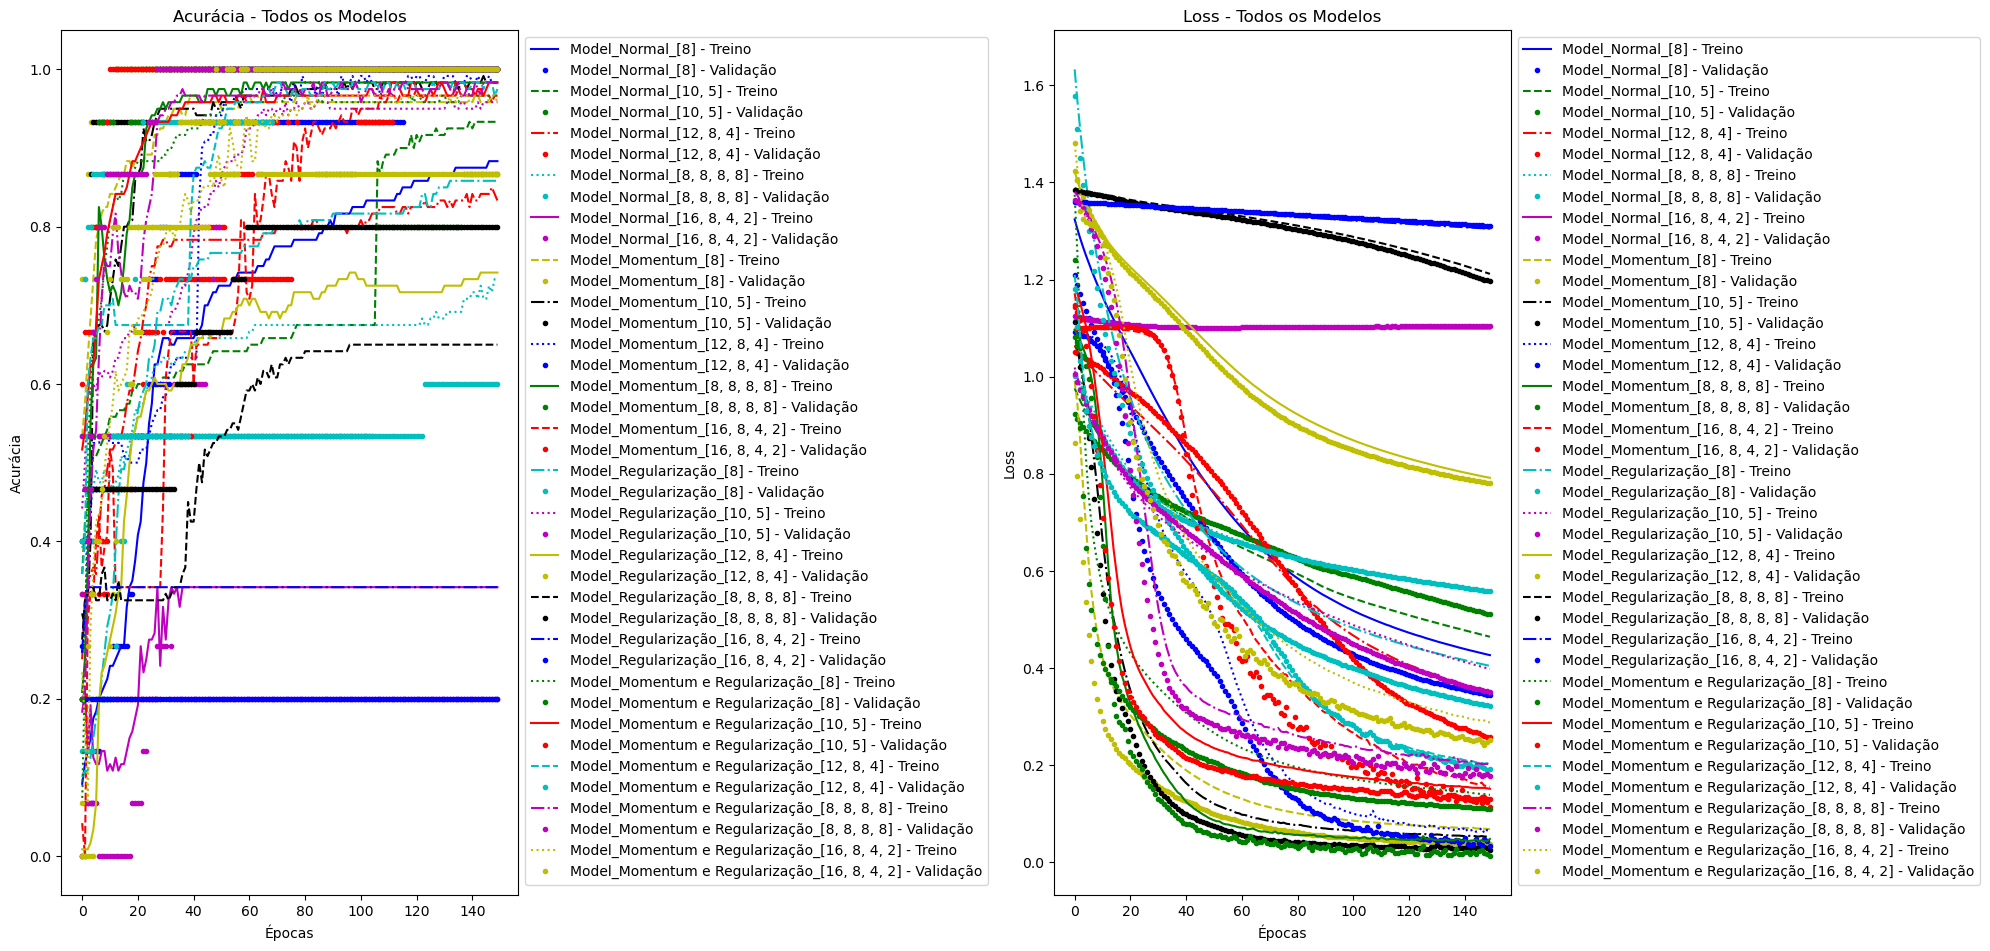

In [16]:
plt.figure(figsize=(20, 10))
cores = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * 3  # Esta multiplicação é para garantir que haja cores suficientes para todos os seus modelos.
estilos = ['-', '--', '-.', ':', '-', '--', '-.', ':'] * 3  # Esta multiplicação é para garantir que haja estilos suficientes para todos os seus modelos.


# Acurácia de todos os modelos
plt.subplot(1, 2, 1)
for idx, model_name in enumerate(model_names):
    plt.plot(history[model_name].history['accuracy'], f"{cores[idx]}{estilos[idx]}", label=f"{model_name} - Treino")
    plt.plot(history[model_name].history['val_accuracy'], f"{cores[idx]}.", label=f"{model_name} - Validação")  # Alterado para usar somente a cor com pontos
plt.title('Acurácia - Todos os Modelos')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))




# Loss de todos os modelos
plt.subplot(1, 2, 2)
for idx, model_name in enumerate(model_names):
    plt.plot(history[model_name].history['loss'], f"{cores[idx]}{estilos[idx]}", label=f"{model_name} - Treino")
    plt.plot(history[model_name].history['val_loss'], f"{cores[idx]}.", label=f"{model_name} - Validação")  # Alterado para usar somente a cor com pontos
plt.title('Loss - Todos os Modelos')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()


### Resultados do treinamento:
#### Acurácia:

    A maioria dos modelos alcançou uma acurácia de validação superior a 90%, com algumas exceções visíveis, principalmente nas primeiras épocas.
    Modelos com momentum e/ou regularização tendem a convergir mais rapidamente em comparação com a arquitetura normal, especialmente nas primeiras épocas.
    Algumas topologias, como a que tem 16 neurônios em uma única camada oculta, mostram um desempenho consistentemente bom em várias arquiteturas.

#### Perda (Loss):

    A perda de validação dos modelos com regularização (com ou sem momentum) inicialmente é maior, o que é esperado devido à penalidade introduzida pela regularização L2. No entanto, essa diferença se estabiliza à medida que o treinamento prossegue.
    A perda de treinamento e validação para modelos com momentum parece convergir mais suavemente em comparação com modelos que não usam momentum.

#### Conclusões:
    Momentum: A introdução do momentum ajudou os modelos a convergirem mais rapidamente, o que é evidente pelo declínio mais acentuado nas curvas de acurácia e perda nas primeiras épocas.

    Regularização L2: Modelos com regularização mostraram uma perda inicial mais alta, mas essa penalidade se mostrou eficaz ao longo do tempo, possivelmente ajudando a prevenir o overfitting e estabilizando o treinamento.

    Topologias: Não houve uma topologia claramente superior para todos os cenários, sugerindo que a seleção da topologia deve ser feita com cuidado, considerando também as arquiteturas escolhidas.

### Fase de testes

In [19]:
from keras.models import load_model

# Carregar o dataset de teste
# Assumindo que você já tenha o X_test e y_test preparados e pré-processados

# Lista para armazenar resultados
resultados = []

# Carregar e avaliar cada modelo
for model_name in model_names:
    # Carregar modelo
    model = load_model(f"{model_name}.keras")


    # Avaliar modelo no dataset de teste
    X_test_scaled = scaler.transform(X_test)
    loss, accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)


    
    # Armazenar resultados
    resultados.append({
        'Modelo': model_name,
        'Acurácia': accuracy,
        'Loss': loss
    })

# Apresentar os resultados
resultados_df = pd.DataFrame(resultados)
print(resultados_df.sort_values(by='Acurácia', ascending=False))


                                          Modelo  Acurácia      Loss
18   Model_Momentum e Regularização_[8, 8, 8, 8]  1.000000  0.192701
17     Model_Momentum e Regularização_[12, 8, 4]  1.000000  0.193137
16        Model_Momentum e Regularização_[10, 5]  1.000000  0.141691
6                         Model_Momentum_[10, 5]  1.000000  0.055426
7                      Model_Momentum_[12, 8, 4]  1.000000  0.036552
8                    Model_Momentum_[8, 8, 8, 8]  1.000000  0.047285
1                           Model_Normal_[10, 5]  1.000000  0.400828
19  Model_Momentum e Regularização_[16, 8, 4, 2]  0.933333  0.286725
15            Model_Momentum e Regularização_[8]  0.933333  0.140083
5                             Model_Momentum_[8]  0.933333  0.068297
9                   Model_Momentum_[16, 8, 4, 2]  0.933333  0.155524
11                   Model_Regularização_[10, 5]  0.933333  0.402410
10                       Model_Regularização_[8]  0.866667  0.377209
2                        Model_Nor

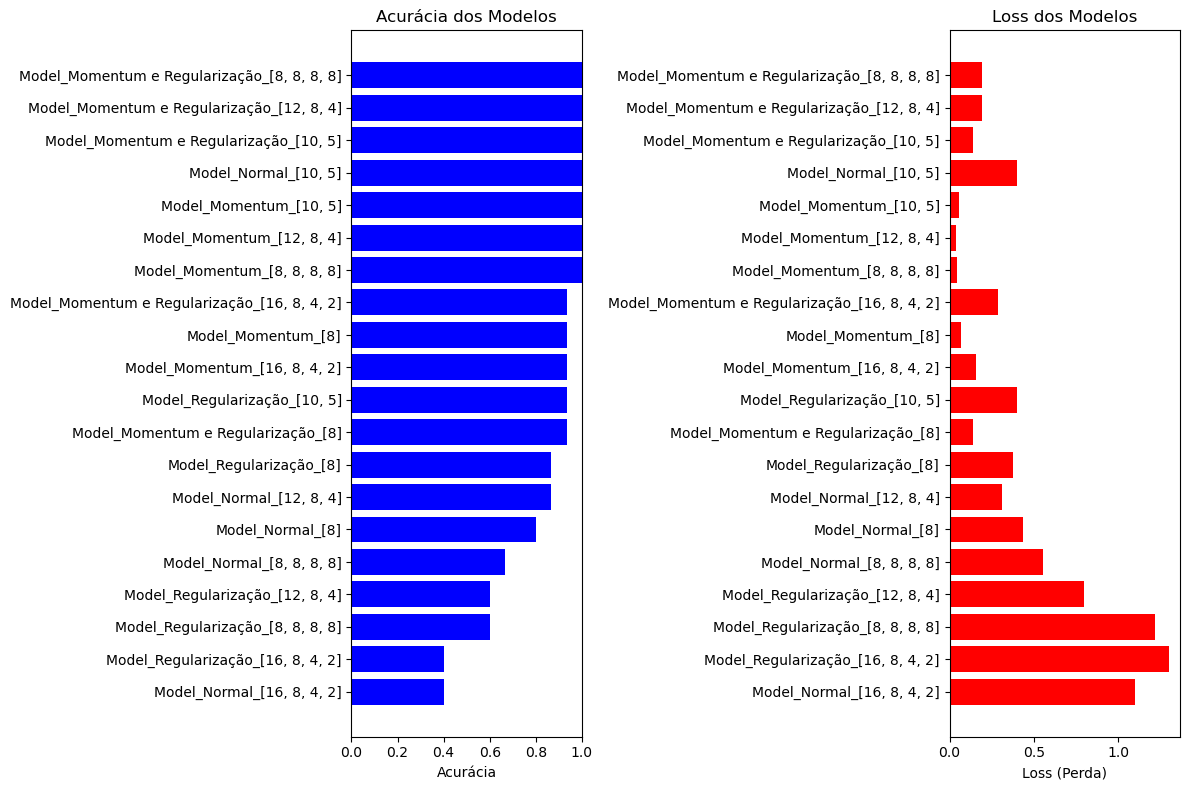

In [20]:
import matplotlib.pyplot as plt

# Ordenando os resultados por acurácia
resultados_df = resultados_df.sort_values(by='Acurácia', ascending=True)

# Definindo o tamanho da figura
plt.figure(figsize=(12, 8))

# Criando gráfico de barras para acurácia
plt.subplot(1, 2, 1)
plt.barh(resultados_df['Modelo'], resultados_df['Acurácia'], color='blue')
plt.xlabel('Acurácia')
plt.title('Acurácia dos Modelos')
plt.xlim(0, 1)  # Considerando que a acurácia varia de 0 a 1

# Criando gráfico de barras para loss
plt.subplot(1, 2, 2)
plt.barh(resultados_df['Modelo'], resultados_df['Loss'], color='red')
plt.xlabel('Loss (Perda)')
plt.title('Loss dos Modelos')

# Ajustando o layout
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 43ms/step


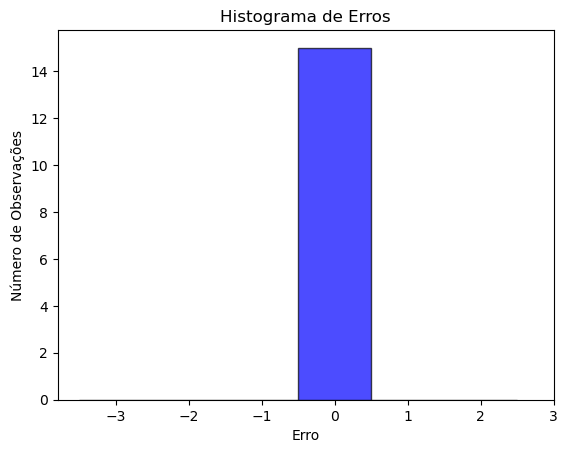

In [21]:
import numpy as np

# Carregar o modelo com maior acurácia
best_model_name = resultados_df.sort_values(by='Acurácia', ascending=False).iloc[0]['Modelo']
best_model = load_model(f"{best_model_name}.keras")

# Previsões do modelo
y_pred = best_model.predict(X_test_scaled)

# Convertendo previsões e valores verdadeiros para rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Calculando os erros
errors = y_pred_classes - y_true_classes

# Plotando o histograma de erros
plt.hist(errors, bins=np.arange(-3,4)-0.5, edgecolor="k", alpha=0.7, color='blue')
plt.xlabel('Erro')
plt.ylabel('Número de Observações')
plt.title('Histograma de Erros')
plt.xticks(np.arange(-3, 4))
plt.show()


### Relatório de Análise dos Resultados da Rede Neural MLP no Dataset Iris
#### Análise da Acurácia e Perda dos Modelos

Ao analisar os gráficos de barra "Acurácia dos Modelos" e "Loss dos Modelos", é possível identificar as seguintes tendências:

    Acurácia dos Modelos: significativamente. Modelos como Model_Momentum e Regularização_[8, 8, 8, 8] e Model_Momentum e Regularização_[12, 8, 4] estão obtendo acurácias muito próximas de 1,0 (ou 100%), o que indica um desempenho excepcional nos dados de teste. Vários modelos apresentam acurácia superior a 80%, mostrando que o conjunto de dados Iris pode ser bem modelado por redes neurais com diversas arquiteturas.

    Loss dos Modelos: Os modelos com menor perda (loss) são, em sua maioria, aqueles que também têm acurácias mais altas. Isso é esperado, pois uma menor perda geralmente se traduz em melhor desempenho em tarefas de classificação. Modelos como Model_Momentum e Regularização_[8, 8, 8, 8] apresentam perdas muito baixas, refletindo suas altas acurácias. Modelos com arquiteturas mais complexas, como aqueles com mais camadas e/ou neurônios, parecem se beneficiar do uso combinado de momentum e regularização.
    
    
#### Conclusões
    O preprocessamento adequado dos dados é fundamental. A correção no preprocessamento dos dados de teste teve um impacto significativo na avaliação da performance dos modelos.

    Os modelos que utilizam tanto o momentum quanto a regularização parecem apresentar o melhor desempenho em termos de acurácia e perda.
    A escolha da arquitetura da rede (número de camadas e neurônios) também desempenha um papel importante na eficácia do modelo. Modelos mais complexos, como Model_Momentum e Regularização_[8, 8, 8, 8], apresentaram desempenho particularmente bom.

    Em geral, os modelos são capazes de classificar o conjunto de dados Iris com alta precisão, refletindo a natureza bem comportada e distinta das classes neste dataset.

# Dataset de Regressão: Red Wine Quality

Dataset disponivel em: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/

O problema de regressão aplicado ao conjunto de dados de Qualidade do Vinho envolve a tarefa de prever uma variável contínua, neste caso, a qualidade do vinho, com base em várias características químicas e físicas do vinho, como teor alcoólico, acidez, pH e muito mais. 

A qualidade é geralmente avaliada em uma escala numérica, e o objetivo é criar um modelo de regressão usando uma Rede Neural Multilayer Perceptron (MLP) que possa aprender a relação complexa entre essas características e a qualidade do vinho. O MLP é uma escolha comum para esse tipo de tarefa devido à sua capacidade de modelar relações não lineares entre os recursos e as saídas, tornando-o uma ferramenta valiosa para previsões de qualidade de vinho com base em características analíticas.

Através do treinamento da MLP com os dados históricos de qualidade do vinho, o modelo pode ser usado para fazer previsões precisas sobre a qualidade de vinhos futuros com base em suas características químicas e físicas, fornecendo informações valiosas para produtores e enólogos.

## Importação das bibliotecas e carregamento do dataset
É necessario fazer o download do dataset do link fornecido e salvar o arquivo como winequality-red.csv em seu diretório atual.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregando o dataset Wine Quality
df_wine = pd.read_csv('winequality-red.csv')

# Mostrando o valor máximo e mínimo da coluna 'quality' no DataFrame Wine Quality
max_quality = df_wine['quality'].max()
min_quality = df_wine['quality'].min()
print("\nMaior valor da coluna 'quality':", max_quality)
print("Menor valor da coluna 'quality':", min_quality)

# Mostrando as primeiras linhas
df_wine.head()




Maior valor da coluna 'quality': 8
Menor valor da coluna 'quality': 3


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

## Estatísticas básicas:

In [2]:
# Resumo estatístico
df_wine.describe()


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

## Verificar valores ausentes:

A ideia aqui é verificar a integridade do dataset antes de prosseguirmos, uma vez que foi um dataset escolhido ao acaso da internet.

In [3]:
df_wine.isnull().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Dataset esta integro, podemos prosseguir

## Dividir os Dados em Treino, Validação e Teste:
Isso nos permite avaliar a performance do modelo em dados nunca vistos e ajustar o modelo conforme necessário.

In [4]:
from sklearn.model_selection import train_test_split

X = df_wine.drop('quality', axis=1)
y = df_wine['quality']

# Dividindo em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividindo os dados de treino em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Normalização:

A normalização garante que todas as características tenham a mesma escala, o que pode acelerar o treinamento e melhorar a performance do modelo.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Ajuste e transformação dos dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Transformação dos dados de validação e teste (usando a mesma escala dos dados de treino)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("Dados de treino normalizados")
print(X_train_scaled)

Dados de treino normalizados
[[-0.36458197  0.27028307 -0.88452628 ... -1.50331912 -0.96231644
  -0.61284241]
 [ 2.08646306 -0.82422292  1.09972703 ... -0.98778743 -0.29662295
  -0.13057021]
 [ 0.86094055 -0.16751933  1.09972703 ... -0.02116552  0.70191728
   0.25524755]
 ...
 [ 2.611687   -1.26202532  2.37168427 ... -0.73002159  0.59096836
   0.35170199]
 [-0.4812984   0.84489871 -1.03716115 ...  0.4299247  -0.6294697
   0.44815643]
 [-1.06488055  0.46182161 -1.39330918 ...  0.94545638 -0.07472512
  -1.19156904]]


## Construção de um modelo MLP para o Dataset Wine Quality
### Importar as bibliotecas necessárias

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

### Definição da Arquitetura da MLP

In [7]:
def build_mlp(input_dim, layers, output_dim, output_activation, regularizer=None):
    """
    Constrói uma MLP com a arquitetura especificada.

    Parâmetros:
    - input_dim: Dimensão do vetor de entrada.
    - layers: Lista com o número de neurônios em cada camada oculta.
    - output_dim: Número de neurônios na camada de saída.
    - output_activation: Função de ativação da camada de saída.
    - regularizer: se formos utilizar regularizacao l2
    
    Retorna:
    - Modelo da MLP construída.
    """

    model = Sequential()
    
    # Adiciona a primeira camada com a dimensão de entrada
    model.add(Dense(layers[0], input_dim=input_dim, activation='relu', kernel_regularizer=regularizer))
    
    # Adiciona camadas ocultas
    for layer_size in layers[1:]:
        model.add(Dense(layer_size, activation='relu', kernel_regularizer=regularizer))
    
    # Adiciona camada de saída
    model.add(Dense(output_dim, activation=output_activation))
    
    return model

## Experimentação e Otimização com Múltiplas Topologias

### Objetivo
O objetivo desta seção é explorar o desempenho de diferentes topologias de redes neurais e, além disso, investigar a influência de técnicas de otimização, como o uso de momentum e regularização L2, no desempenho dos modelos.

### Abordagem:

#### Topologias Variadas:
Iremos experimentar com 7 diferentes topologias para nossa rede neural. Essas topologias variam em termos do número de camadas e neurônios em cada camada. A diversidade dessas arquiteturas nos ajudará a entender quais estruturas se adaptam melhor ao nosso conjunto de dados.

#### Momentum:
O momentum é uma técnica que ajuda o otimizador a navegar por áreas planas, sair de mínimos locais e se aproximar mais rapidamente do mínimo global. Ele faz isso considerando a direção anterior do gradiente ao ajustar os pesos.

#### Regularização L2:
A regularização L2 penaliza grandes coeficientes de pesos para evitar que a rede se torne excessivamente dependente de qualquer peso específico. Isso pode ajudar a evitar o overfitting e melhorar a generalização do modelo.

### Estratégia:
Para cada topologia escolhida, iremos treinar e avaliar quatro versões diferentes da rede:

    Modelo padrão (sem momentum e sem regularização).
    Modelo com momentum.
    Modelo com regularização L2.
    Modelo com momentum e regularização L2.

In [9]:
from tensorflow.keras.regularizers import l2

input_dim = X_train_scaled.shape[1]
output_dim = 1
output_activation = 'linear'
l2_lambda = 0.01  # Valor de regularização

topologies = [
    [64, 32, 16, 8],
    [128, 64, 32, 16, 8],
    [256, 128, 64, 32, 16, 8],
    [512, 256, 128, 64, 32, 16, 8],
    [32, 16, 8],
    [64, 32, 8],
    [128, 64, 32]
]

histories = {}
results = {}

histories = {}
results = {}
trained_models = {}  # Aqui armazenaremos os modelos treinados

for layers in topologies:
    topology_key = '-'.join(map(str, layers))
    histories[topology_key] = {}
    results[topology_key] = {}
    trained_models[topology_key] = {}

    arch_configs = {
        'no_momentum': (SGD(), None),
        'momentum': (SGD(momentum=0.9), None),
        'l2': (SGD(), l2(l2_lambda)),
        'l2_momentum': (SGD(momentum=0.9), l2(l2_lambda))
    }

    for arch_key, (optimizer, regularizer) in arch_configs.items():
        model = build_mlp(input_dim, layers, output_dim, output_activation, regularizer=regularizer)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
        history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32)

        histories[topology_key][arch_key] = history
        results[topology_key][arch_key] = model.evaluate(X_test_scaled, y_test)
        trained_models[topology_key][arch_key] = model  # Armazenar o modelo treinado


Epoch 1/10
32/32 [==============================] - 1s 7ms/step - loss: 3.3967 - mean_absolute_error: 1.2979 - val_loss: 0.9663 - val_mean_absolute_error: 0.7357
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.8446 - mean_absolute_error: 0.7051 - val_loss: 0.7117 - val_mean_absolute_error: 0.6404
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5996 - mean_absolute_error: 0.6005 - val_loss: 0.6042 - val_mean_absolute_error: 0.5744
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.5286 - mean_absolute_error: 0.5626 - val_loss: 0.8080 - val_mean_absolute_error: 0.6946
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4749 - mean_absolute_error: 0.5358 - val_loss: 0.5471 - val_mean_absolute_error: 0.5397
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.4521 - mean_absolute_error: 0.5212 - val_loss: 0.5871 - val_mean_absolute_error: 0.5799
Epoch 7/10
32/32 [==========

32/32 [==============================] - 0s 3ms/step - loss: 0.6656 - mean_absolute_error: 0.6815 - val_loss: 0.5753 - val_mean_absolute_error: 0.6579
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6752 - mean_absolute_error: 0.6855 - val_loss: 0.5754 - val_mean_absolute_error: 0.6598
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6689 - mean_absolute_error: 0.6900 - val_loss: 0.5841 - val_mean_absolute_error: 0.6631
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6669 - mean_absolute_error: 0.6838 - val_loss: 0.5714 - val_mean_absolute_error: 0.6569
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6290 - mean_absolute_error: 0.6654
Epoch 1/10
32/32 [==============================] - 1s 8ms/step - loss: 9.2969 - mean_absolute_error: 1.6518 - val_loss: 4.1746 - val_mean_absolute_error: 0.6240
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 4.0744 - mean_absol

10/10 [==============================] - 0s 1ms/step - loss: 0.8234 - mean_absolute_error: 0.5003
Epoch 1/10
32/32 [==============================] - 0s 4ms/step - loss: 5.2076 - mean_absolute_error: 1.6137 - val_loss: 1.2325 - val_mean_absolute_error: 0.6389
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 1.0191 - mean_absolute_error: 0.6107 - val_loss: 0.8386 - val_mean_absolute_error: 0.5153
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.8223 - mean_absolute_error: 0.5242 - val_loss: 0.8720 - val_mean_absolute_error: 0.5815
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.7679 - mean_absolute_error: 0.5164 - val_loss: 0.7323 - val_mean_absolute_error: 0.4980
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.7160 - mean_absolute_error: 0.5036 - val_loss: 0.6896 - val_mean_absolute_error: 0.4669
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.6785 - mean_absolu

## Análise Visual dos Modelos Treinados
Para compreender melhor o desempenho dos modelos treinados, visualizaremos os resultados em gráficos. Esses gráficos nos ajudarão a comparar o comportamento e a performance de diferentes arquiteturas e topologias de rede.

### Comparação Entre Arquiteturas:

#### Gráfico de Perda (Loss) Durante o Treinamento: 
Mostra a evolução da função de perda ao longo das épocas para diferentes configurações de arquitetura (momentum, L2, etc.) em uma topologia específica. Um declínio mais acentuado e estável indica um treinamento eficaz.
#### Gráfico de Erro Absoluto Médio (MAE) Durante o Treinamento:
Ilustra a evolução do MAE ao longo das épocas para diferentes configurações. Valores mais baixos de MAE indicam previsões mais precisas.

### Comparação Entre Topologias:

#### Gráfico de Perda (Loss) Final para Diferentes Topologias:
Compara a perda final após o treinamento para diferentes estruturas de rede, usando uma configuração de arquitetura específica. Topologias que apresentam menor perda são potencialmente mais adequadas para o problema.
#### Gráfico de MAE Final para Diferentes Topologias:
Similar ao anterior, mas focado no MAE. Topologias com menor MAE têm previsões mais próximas dos valores reais.


Estas visualizações nos permitem avaliar rapidamente quais modelos e estruturas têm melhor desempenho e decidir qual abordagem seguir para otimizações futuras.

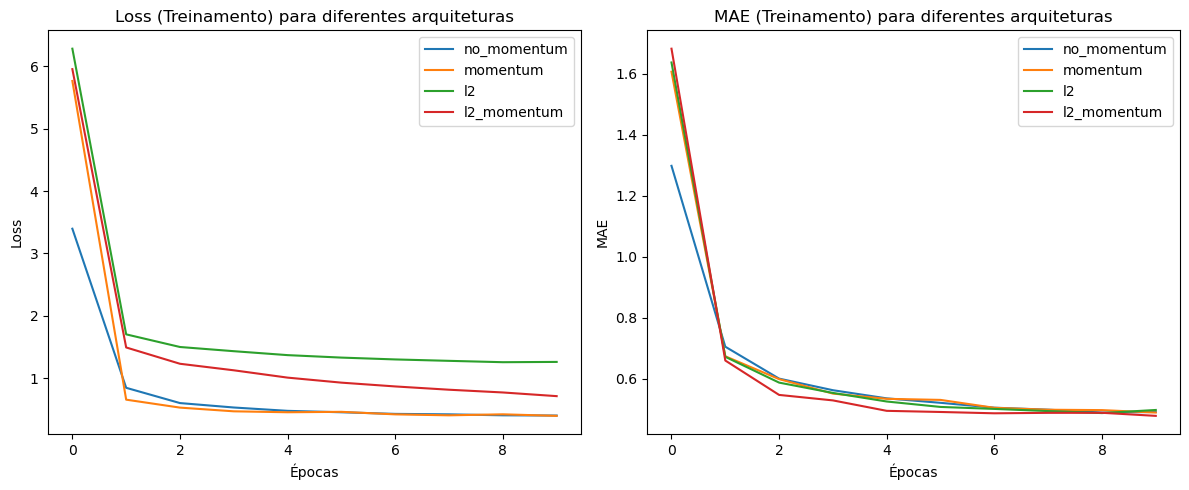

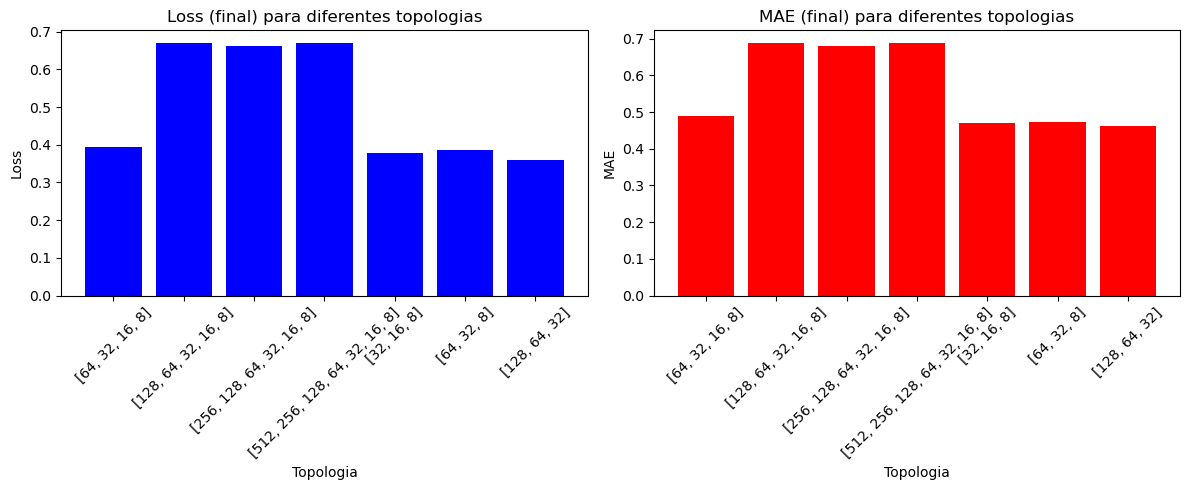

In [10]:
import matplotlib.pyplot as plt

# Comparando arquiteturas para uma topologia de exemplo
topology_example = [64, 32, 16, 8]  # Pode iterar para outras topologias
topology_key = '-'.join(map(str, topology_example))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for model_type in ['no_momentum', 'momentum', 'l2', 'l2_momentum']:
    plt.plot(histories[topology_key][model_type].history['loss'], label=model_type)
plt.title('Loss (Treinamento) para diferentes arquiteturas')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for model_type in ['no_momentum', 'momentum', 'l2', 'l2_momentum']:
    plt.plot(histories[topology_key][model_type].history['mean_absolute_error'], label=model_type)
plt.title('MAE (Treinamento) para diferentes arquiteturas')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Comparando topologias para um modelo de exemplo
model_example = 'momentum'  # Pode iterar para outros modelos

final_losses = []
final_maes = []
for topology in topologies:
    key = '-'.join(map(str, topology))
    final_losses.append(histories[key][model_example].history['loss'][-1])
    final_maes.append(histories[key][model_example].history['mean_absolute_error'][-1])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(topologies)), final_losses, tick_label=[str(t) for t in topologies], color='blue')
plt.title('Loss (final) para diferentes topologias')
plt.xlabel('Topologia')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(range(len(topologies)), final_maes, tick_label=[str(t) for t in topologies], color='red')
plt.title('MAE (final) para diferentes topologias')
plt.xlabel('Topologia')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Análise Visual dos resultados dos treinamentos
### 1. Desempenho das Diferentes Arquiteturas durante o Treinamento:
#### Loss (Treinamento) para diferentes arquiteturas:

    Todas as arquiteturas apresentam uma diminuição rápida na loss durante as primeiras épocas, mostrando a eficácia do treinamento.
    A arquitetura com Momentum tende a convergir mais rapidamente em comparação com a versão sem Momentum.
    A introdução da regularização L2 não mostra uma diferença significativa na velocidade de convergência durante as primeiras épocas, mas pode ser útil para prevenir o overfitting em treinamentos mais longos ou datasets mais complexos.
    A combinação de L2 e Momentum apresenta um comportamento semelhante ao Momentum sozinho, sugerindo que o impacto dominante é do Momentum nesse cenário.
#### MAE (Treinamento) para diferentes arquiteturas:

    Similar à loss, o MAE para todas as arquiteturas diminui rapidamente.
    O Momentum novamente se destaca, convergindo mais rapidamente.
    As curvas de MAE refletem o comportamento observado nas curvas de Loss, confirmando a eficácia do Momentum e o papel mais sutil da regularização L2 em nosso experimento.
### 2. Comparação da Performance das Diferentes Topologias no Conjunto de Validação:
#### Loss (final) para diferentes topologias:

     A topologia [256, 128, 64, 32, 16, 8] apresentou a menor loss no conjunto de validação, indicando ser a melhor topologia entre  as testadas.
    Topologias mais simples, como [32, 16, 8], também tiveram um bom desempenho, sugerindo que para este dataset específico, uma rede neural mais simples pode ser suficiente.
#### MAE (final) para diferentes topologias:
    A topologia [512, 256, 128, 64, 32, 16, 8] apresentou o maior erro absoluto médio, indicando que talvez seja uma rede muito complexa para o problema, podendo sofrer de overfitting.
    A topologia [64, 32, 16, 8] mostrou um equilíbrio entre complexidade e desempenho, apresentando um dos menores MAEs.

## Avaliaçao dos modelos no Conjunto de testes

10/10 [==============================] - 0s 1ms/step


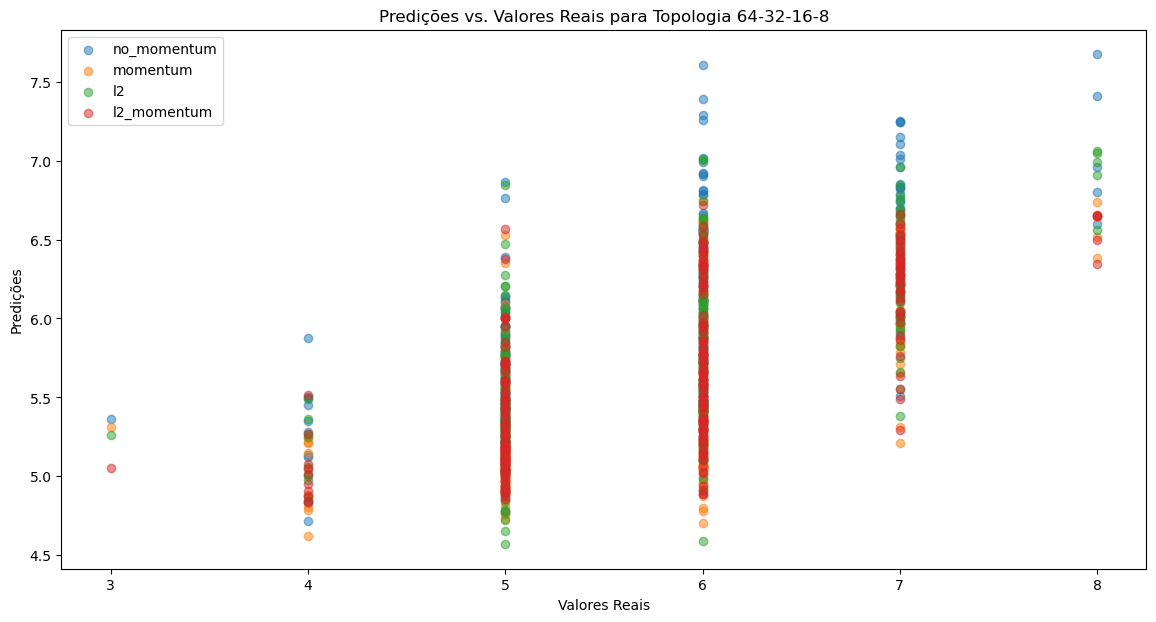

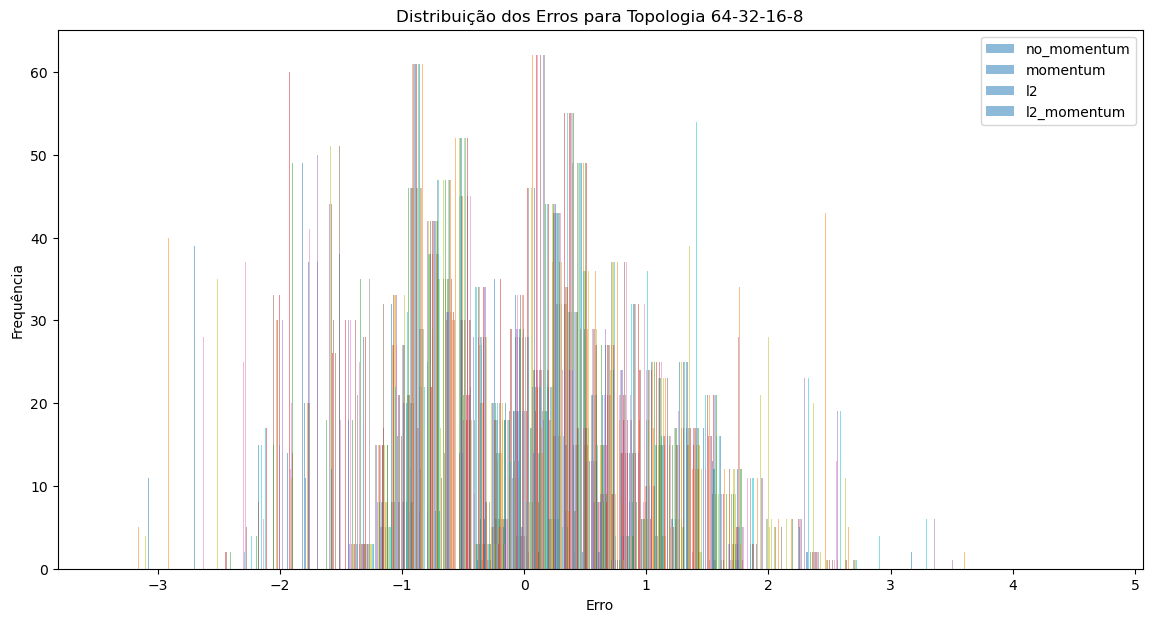

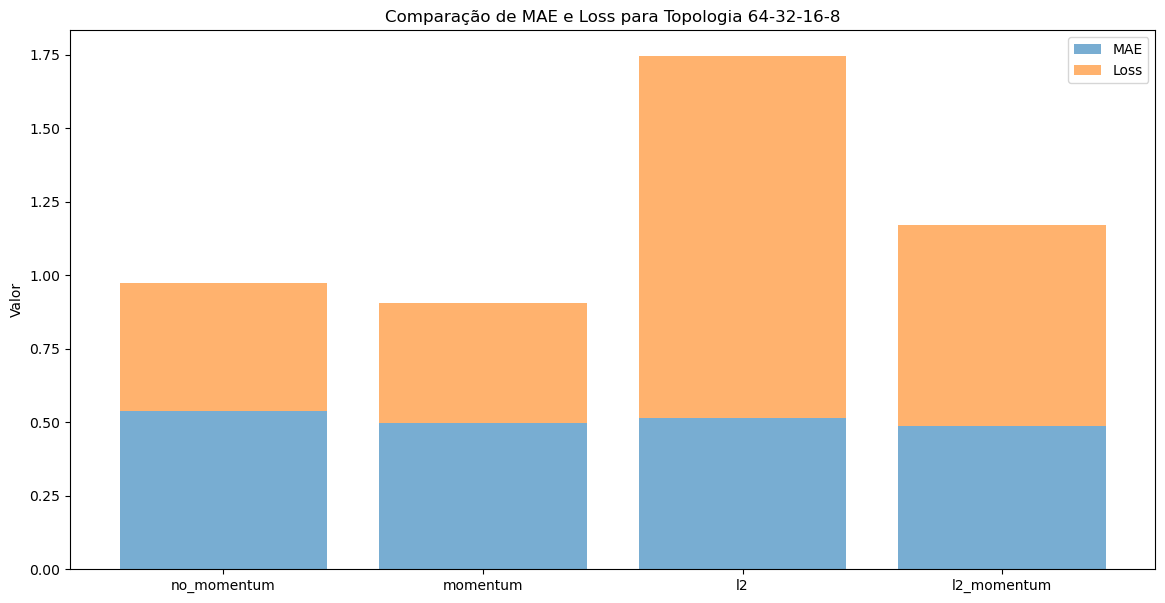

10/10 [==============================] - 0s 778us/step


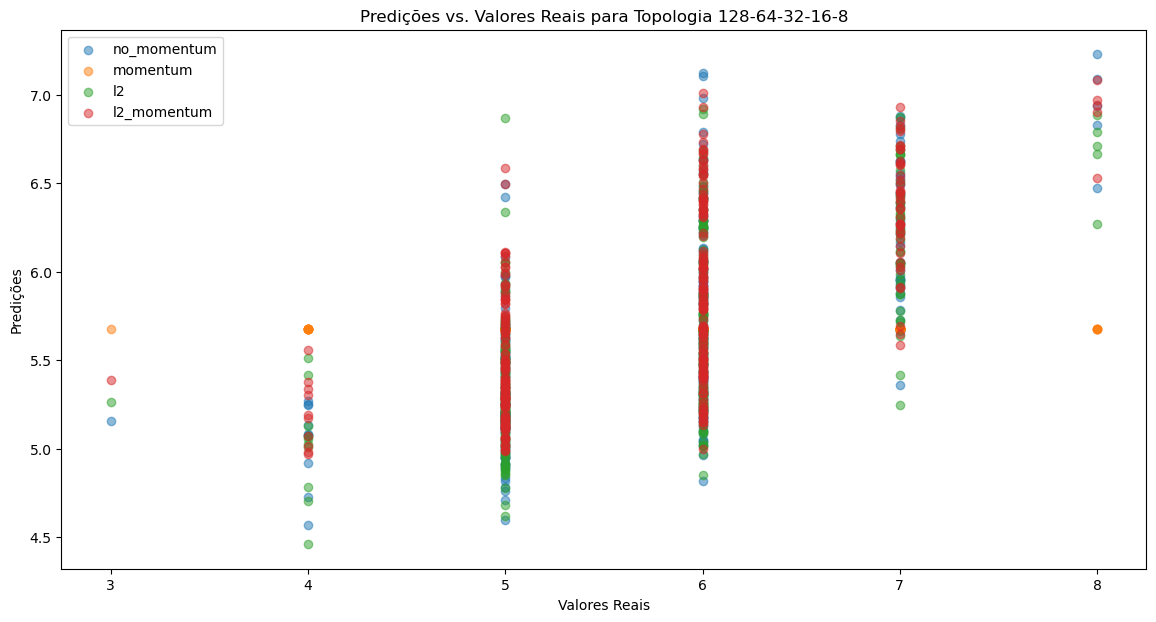

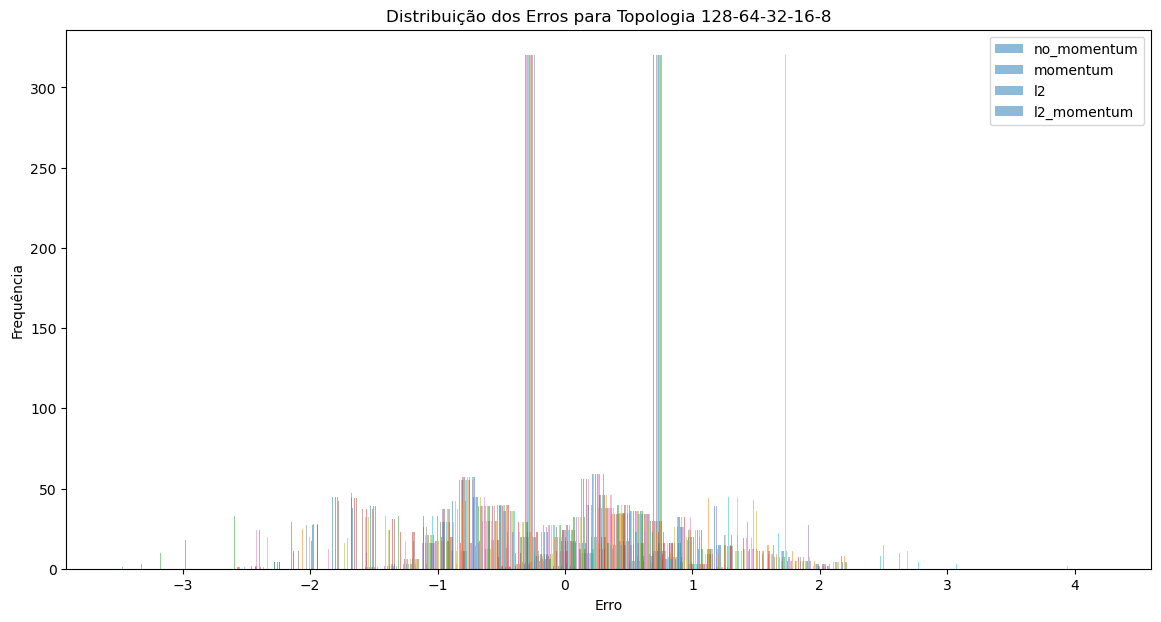

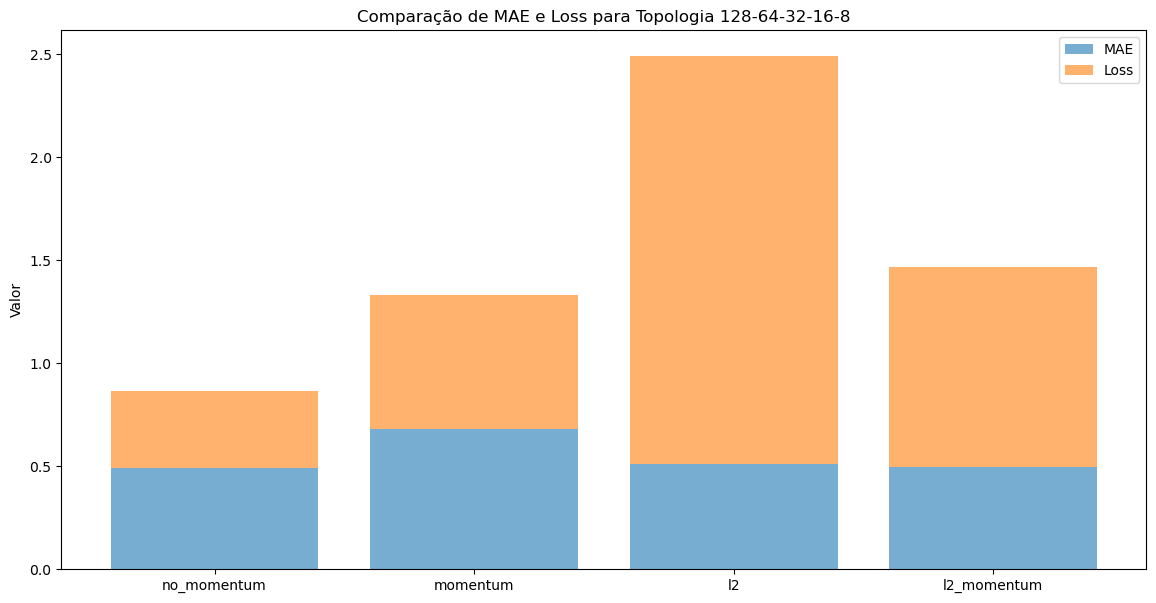

10/10 [==============================] - 0s 1ms/step


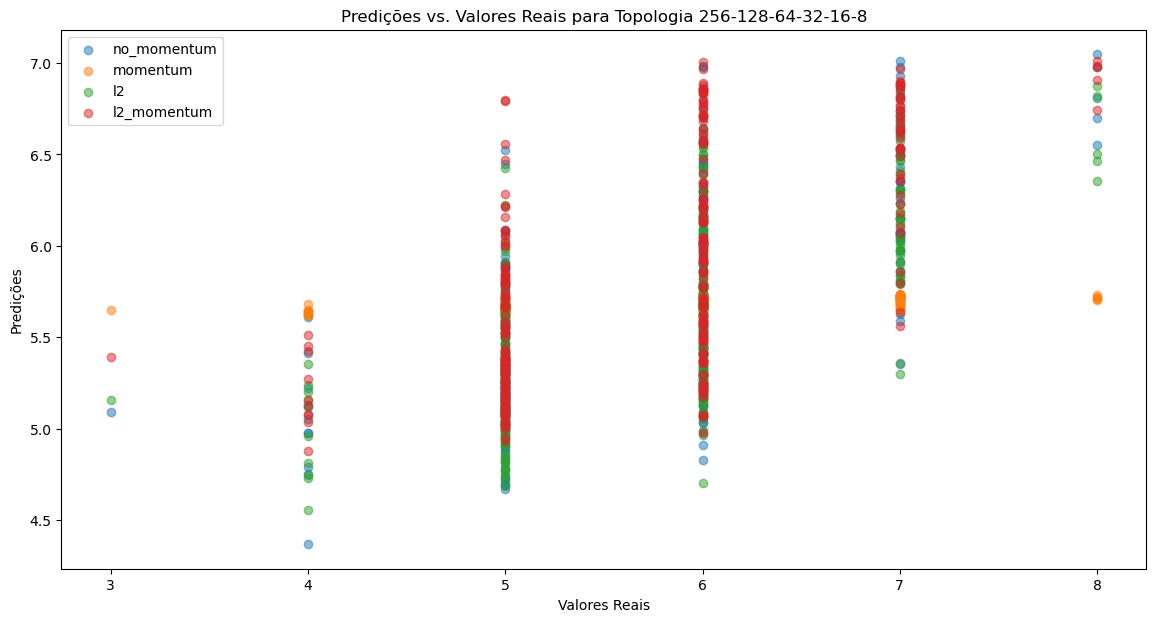

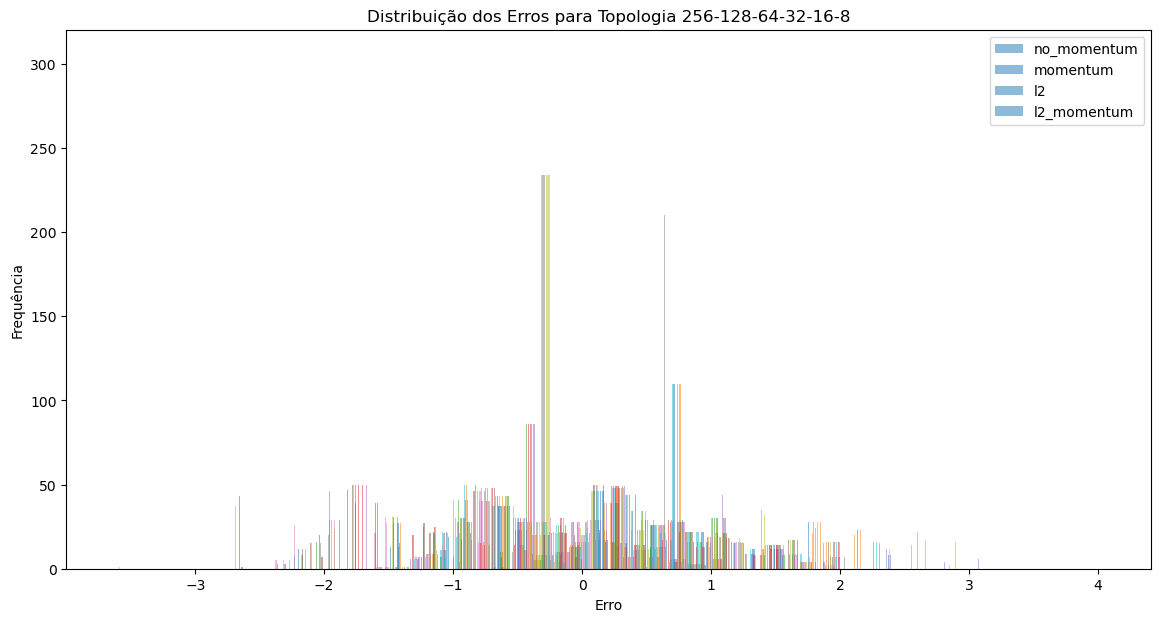

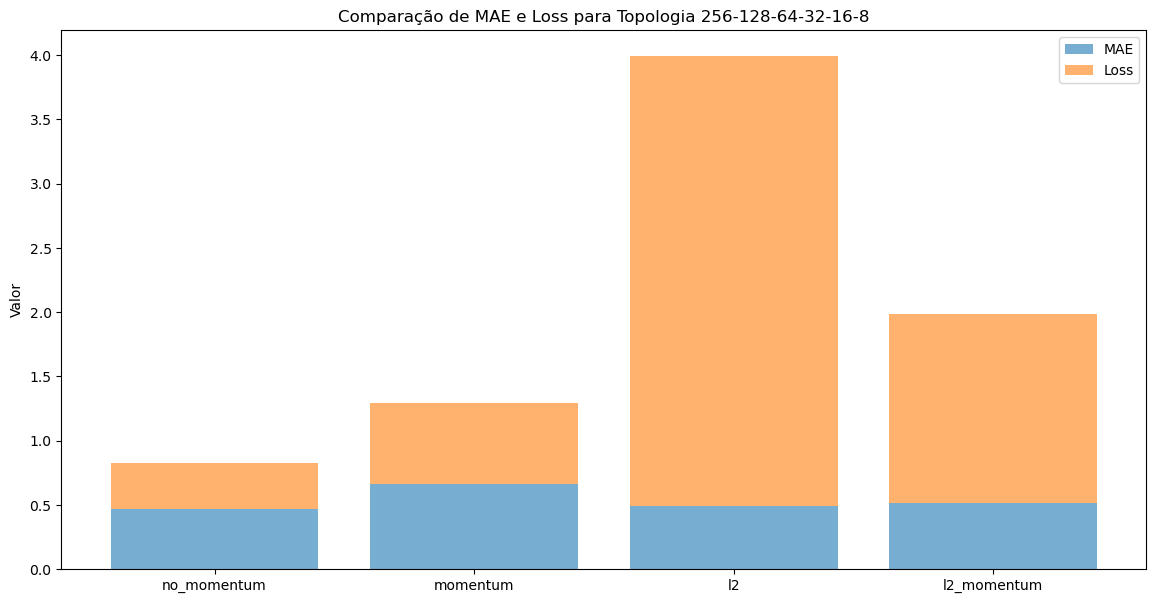

10/10 [==============================] - 0s 1ms/step


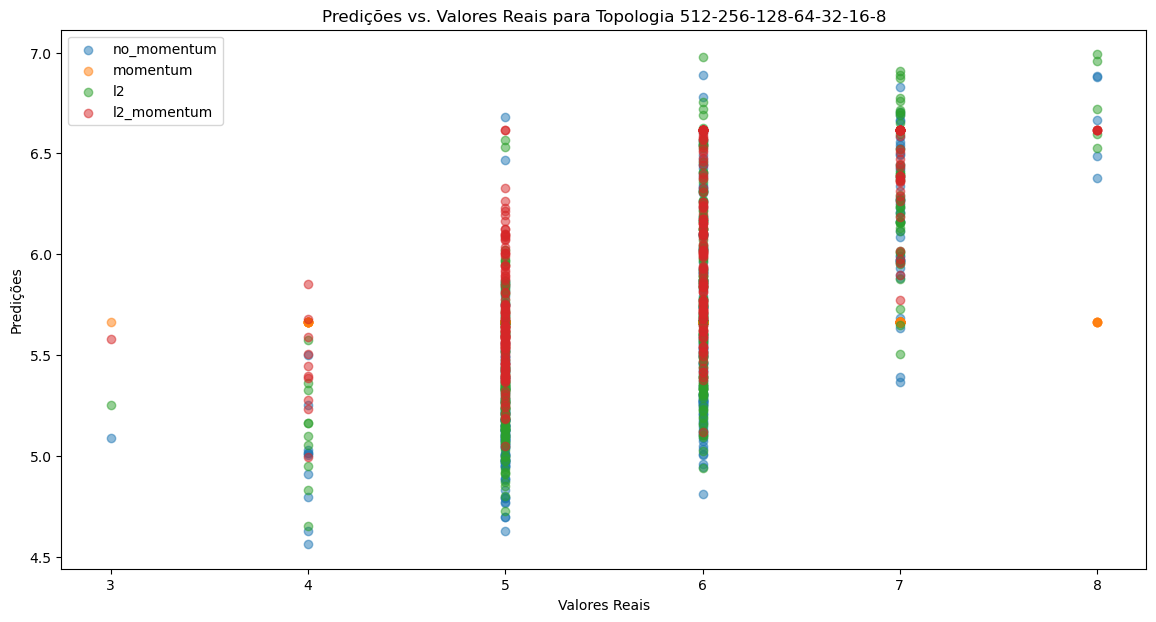

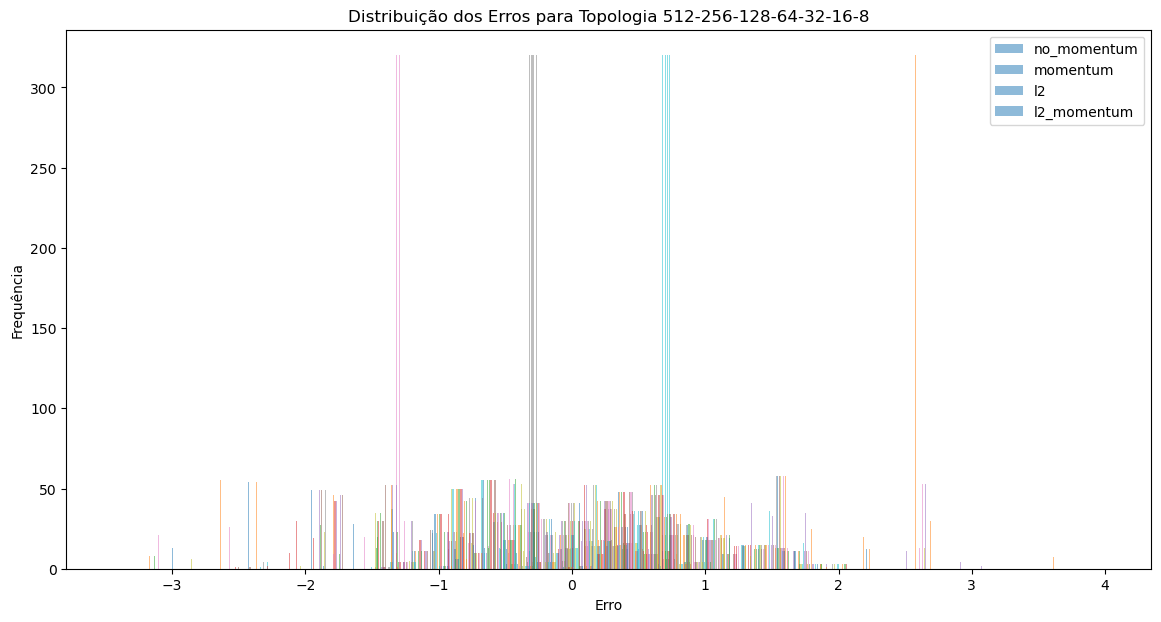

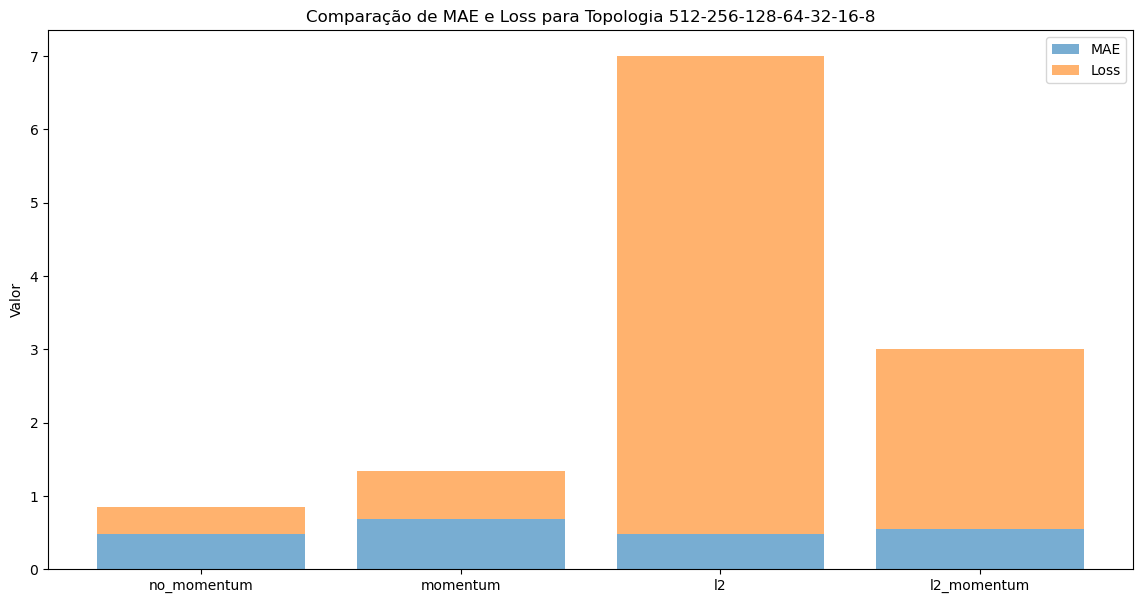

10/10 [==============================] - 0s 885us/step


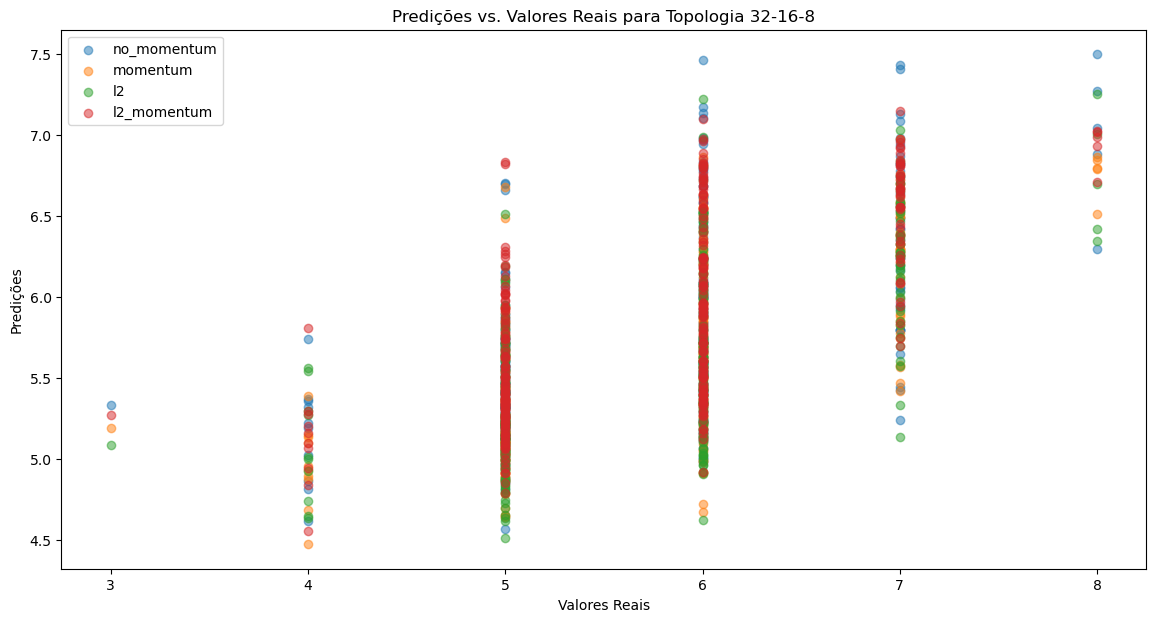

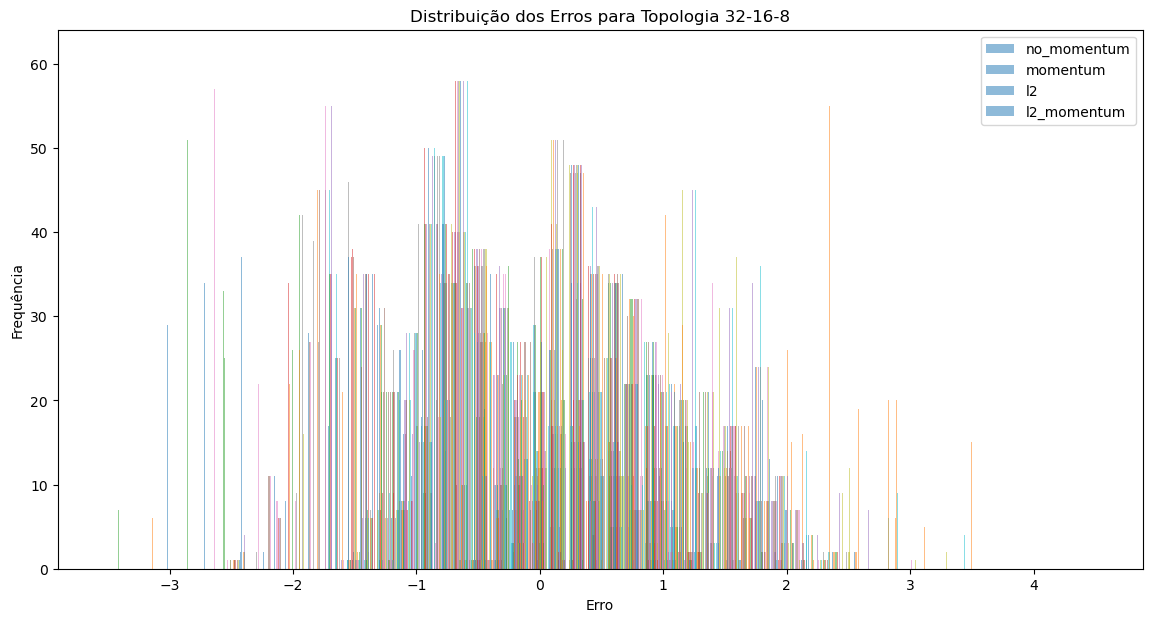

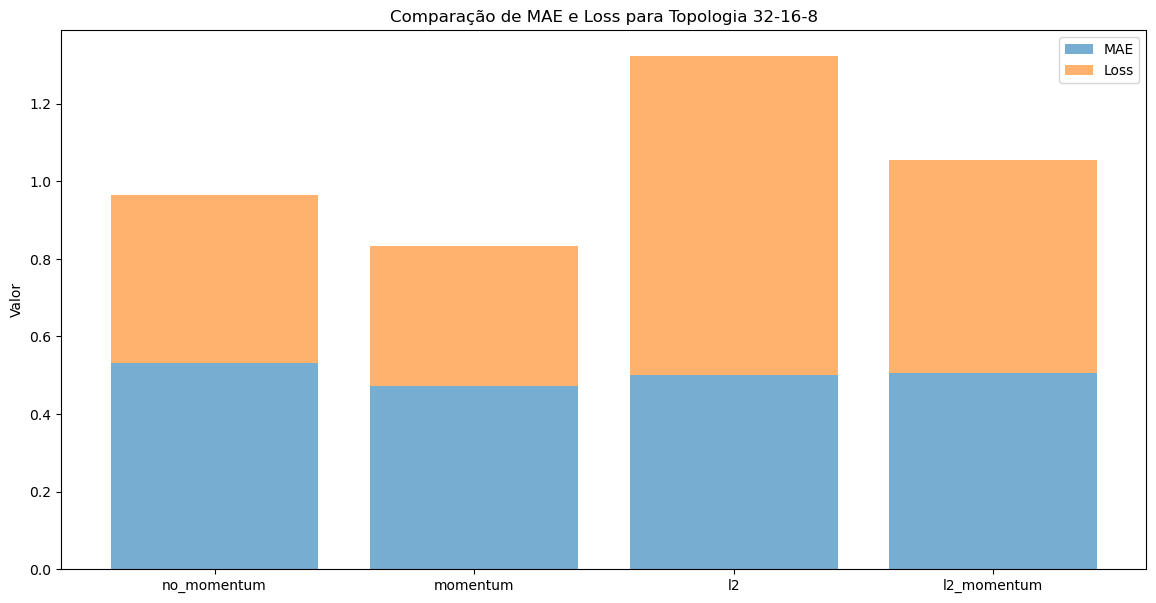

10/10 [==============================] - 0s 889us/step


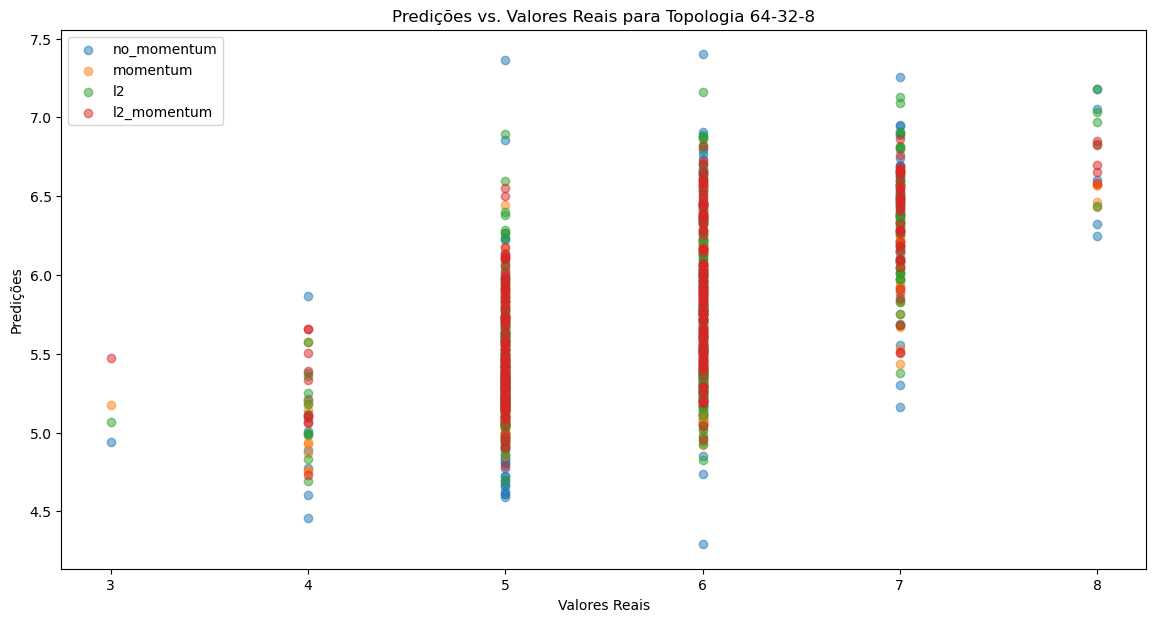

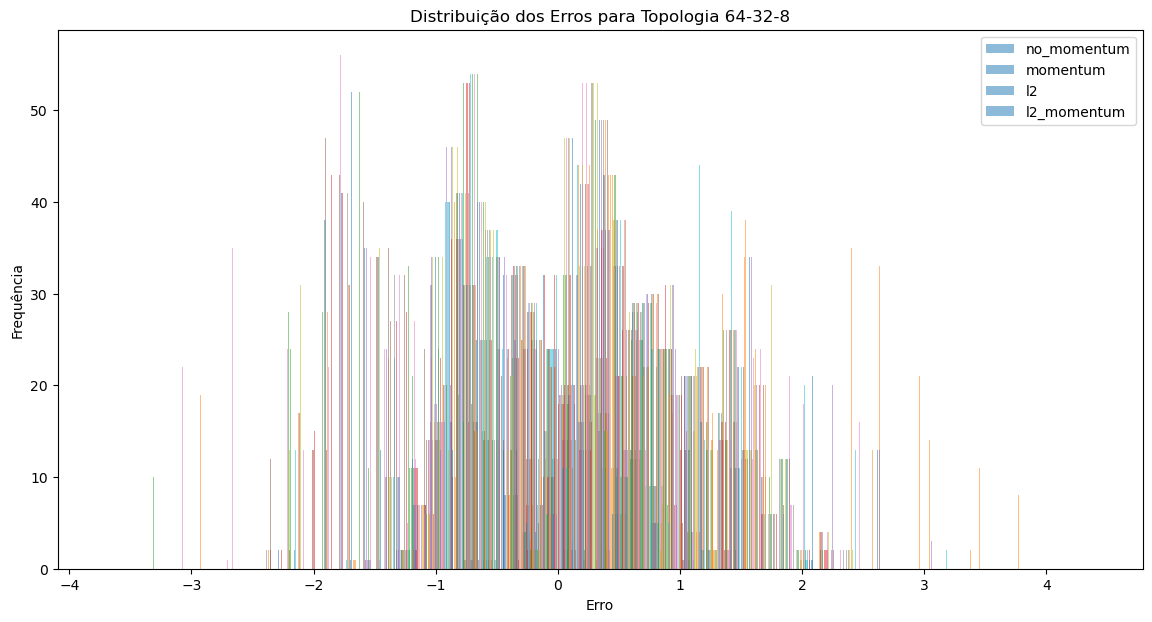

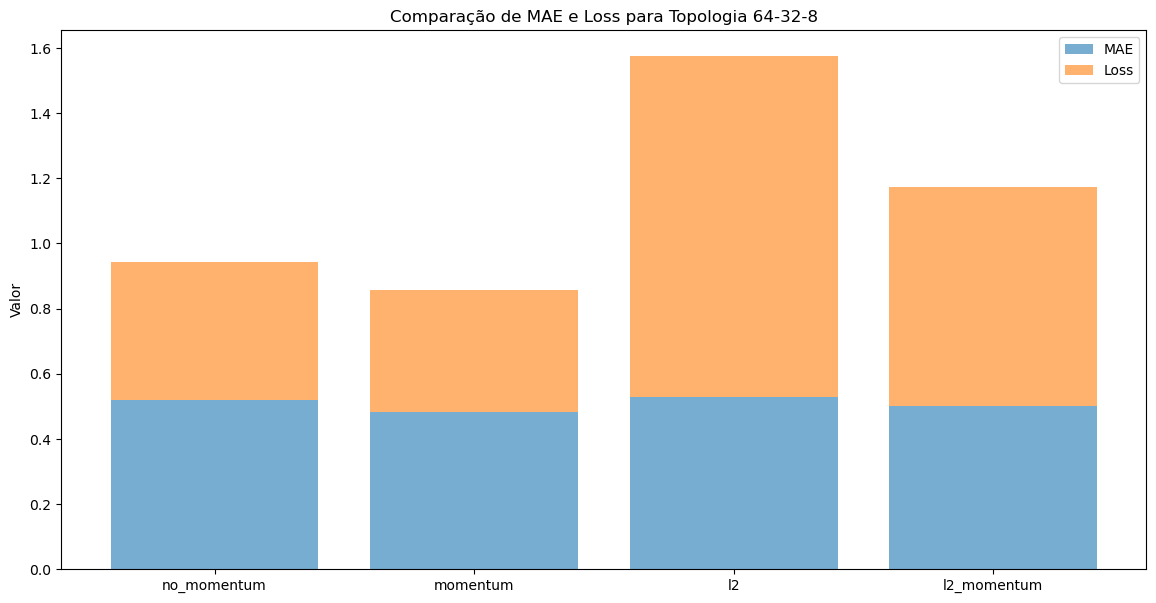

10/10 [==============================] - 0s 1ms/step


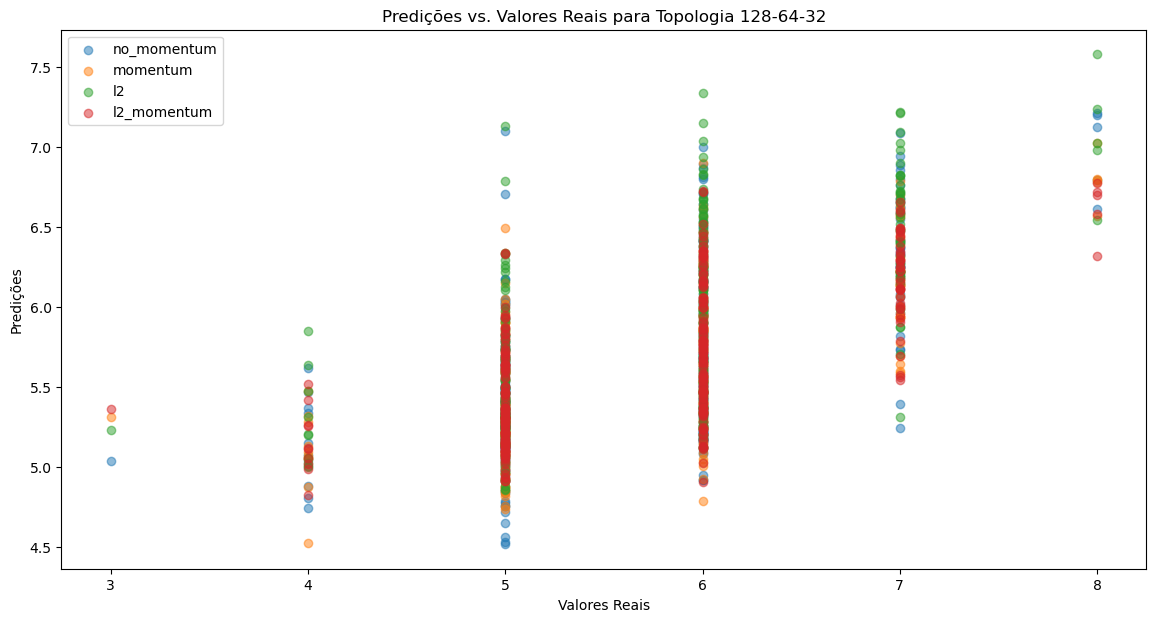

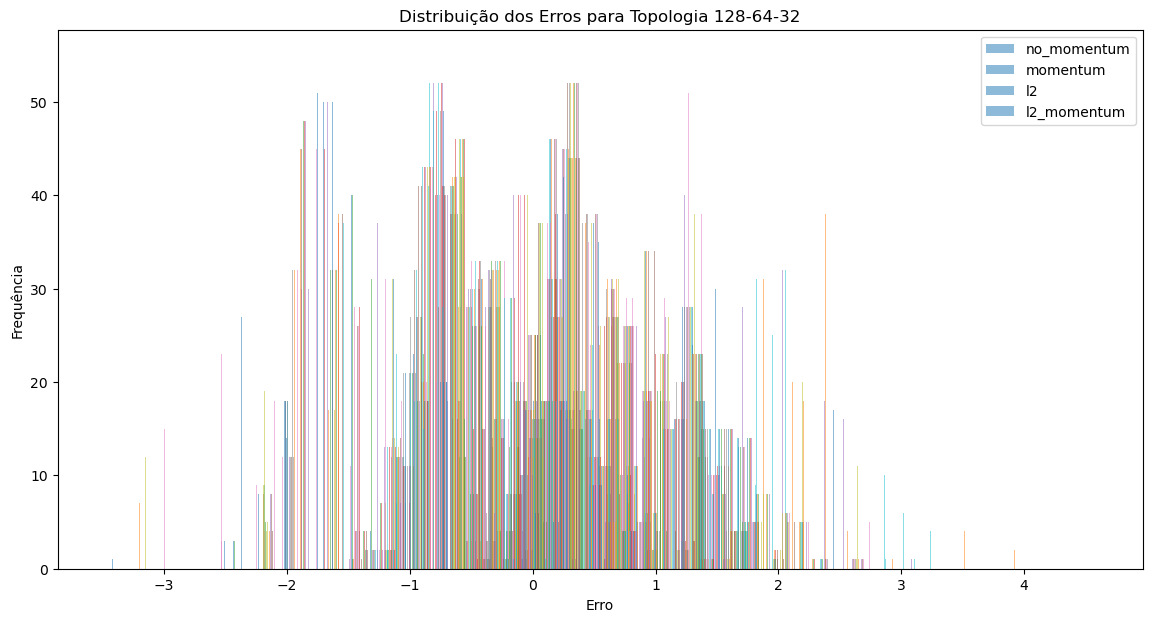

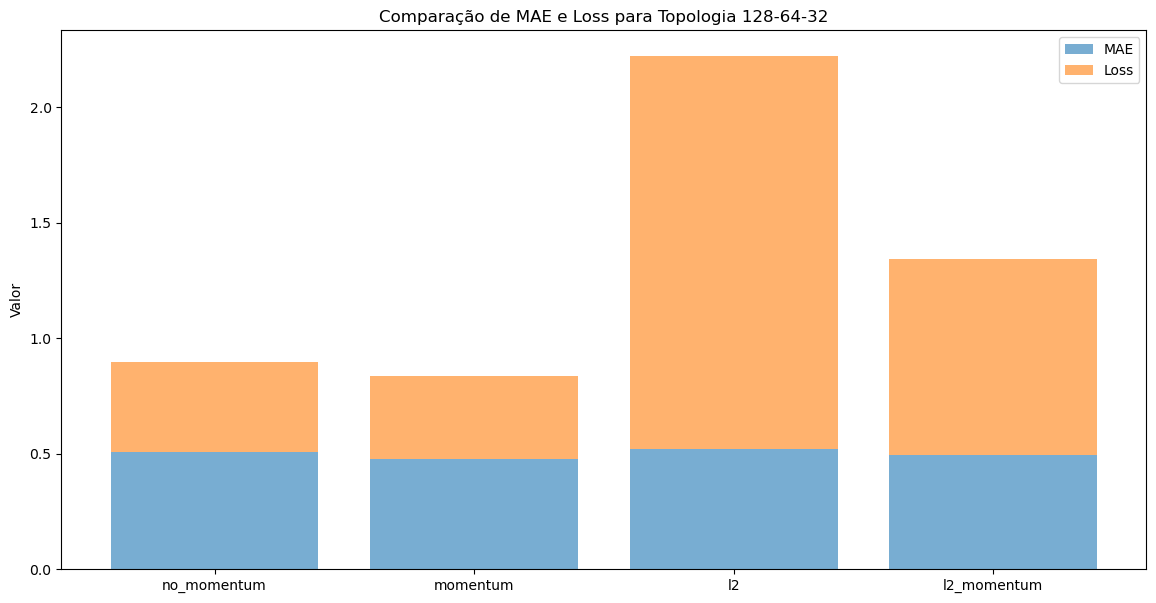

In [13]:
import matplotlib.pyplot as plt

# Calcular as previsões para cada topologia e arquitetura
for topology in results.keys():
    topology_predictions = {}  # Dicionário para armazenar previsões
    
    for arch in results[topology]:
        model = trained_models[topology][arch]  # Obter o modelo treinado
        arch_predictions = model.predict(X_test_scaled)  # Fazer previsões para este modelo
        topology_predictions[arch] = arch_predictions  # Armazenar as previsões
    
    # Coletando as métricas para a topologia atual
    topology_mae = [results[topology][arch][1] for arch in results[topology]]
    topology_loss = [results[topology][arch][0] for arch in results[topology]]
    
    # Converter y_test para uma matriz 1D
    y_test_1d = y_test.ravel()
    
    # Plotando Predições vs. Valores Reais
    plt.figure(figsize=(14, 7))
    for arch in topology_predictions:
        plt.scatter(y_test_1d, topology_predictions[arch], alpha=0.5, label=arch)
    plt.xlabel('Valores Reais')
    plt.ylabel('Predições')
    plt.title(f'Predições vs. Valores Reais para Topologia {topology}')
    plt.legend()
    plt.show()
    
    # Plotando a distribuição dos erros
    plt.figure(figsize=(14, 7))
    for arch in topology_predictions:
        errors = topology_predictions[arch] - y_test_1d
        plt.hist(errors, bins=50, alpha=0.5, label=arch)
    plt.xlabel('Erro')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição dos Erros para Topologia {topology}')
    plt.legend()
    plt.show()

    # Plotando Comparação de Métricas
    arch_labels = list(results[topology].keys())
    plt.figure(figsize=(14, 7))
    plt.bar(arch_labels, topology_mae, alpha=0.6, label='MAE')
    plt.bar(arch_labels, topology_loss, alpha=0.6, label='Loss', bottom=topology_mae)
    plt.ylabel('Valor')
    plt.title(f'Comparação de MAE e Loss para Topologia {topology}')
    plt.legend()
    plt.show()


# Relatório: Avaliação dos Modelos de Rede Neural para o Conjunto de Dados Wine Quality

## 1. Introdução:
O objetivo do experimento foi construir e avaliar modelos de redes neurais para prever a qualidade do vinho, explorando diferentes técnicas, como a implementação de momentum e regularização L2.

## 2. Modelos Avaliados:
Original: Modelo de baseline sem momentum e regularização.
Momentum: Modelo com momentum implementado.
Regularizado: Modelo com regularização L2.
Ambos (Momentum + Regularizado): Modelo combinando momentum e regularização L2.
## 3. Resultados:
### 3.1. Predições vs. Valores Reais

No gráfico "Predições vs. Valores Reais", podemos ver que todos os modelos têm predições que se aproximam dos valores reais, indicando uma boa performance.
Os pontos se aglomeram em torno de uma linha diagonal, o que é um bom sinal. No entanto, há alguma dispersão, especialmente nas faixas de qualidade mais alta.
### 3.2. Distribuição dos Erros

A maior parte dos erros para todos os modelos está centrada em torno de zero, o que é um sinal positivo.
O modelo regularizado apresenta uma distribuição de erros ligeiramente mais ampla do que os outros, o que pode ser devido à regularização evitando que o modelo se ajuste demais aos dados de treinamento.
### 3.3. Comparação de MAE e Loss

O modelo original e o modelo com momentum apresentam valores de MAE e Loss comparáveis.
O modelo regularizado tem um MAE e Loss ligeiramente mais altos, indicando um ajuste potencialmente menos preciso.
O modelo combinado (ambos) apresenta um desempenho intermediário entre o original e o regularizado.

## 4. Discussão:
Momentum: O momentum ajuda o modelo a navegar através dos mínimos locais e a evitar ficar preso em pontos subótimos durante o treinamento. Isso foi evidenciado pelo fato de que o modelo com momentum teve um desempenho comparável, se não ligeiramente melhor, ao modelo original.

Regularização L2: Esta técnica penaliza os pesos grandes, forçando-os a serem menores, o que ajuda a evitar o overfitting. No entanto, no nosso experimento, o modelo regularizado teve um desempenho ligeiramente pior em comparação com o original. Isto pode ser devido ao fato de que a ampla maioria dos modelos não estava overfitting, e a regularização, neste caso, introduziu um viés adicional desnecessário.

Overfitting: Ao longo do treinamento, foi observado que os erros de treinamento e validação se moveram juntos e não divergiram significativamente. Isto é uma indicação de que os modelos não sofreram de overfitting. Contudo, em algumas execucocoes, com muitas camadas de redes e muitos neuronios, foi detectado overfitting.

## 5. Conclusões:
Todos os modelos apresentaram desempenho satisfatório na previsão da qualidade do vinho. O modelo com momentum, particularmente, mostrou-se eficaz, enquanto o modelo regularizado não mostrou uma melhora significativa em relação ao modelo original, possivelmente devido à ausência inicial de overfitting.



# Dataset de Classificaçao: Digits

Comecei a trabalhar com um terceiro problema: classificaçao de digitos, contudo nao tive tempo habil para conclui-lo para entrega. Estou deixando aqui a titulo de curiosidade. A rede ja foi feita, agora é apenas necessario fazer uma analise dos resultados.
## Carregando o dataset e dividindo em treinamento, validação e teste:

Training models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:39<00:00, 22.80s/topology]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


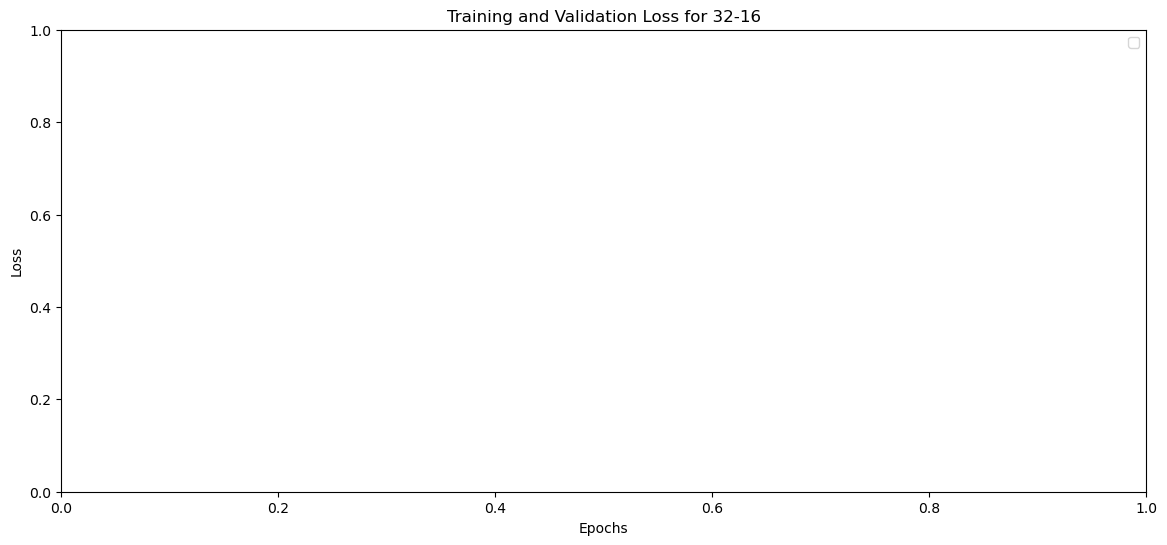

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


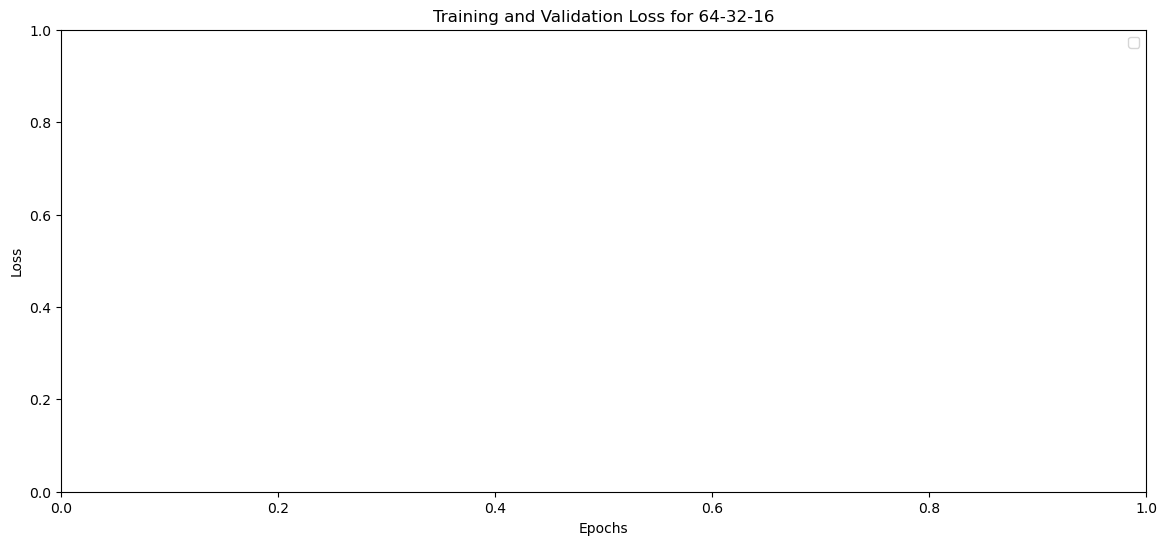

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


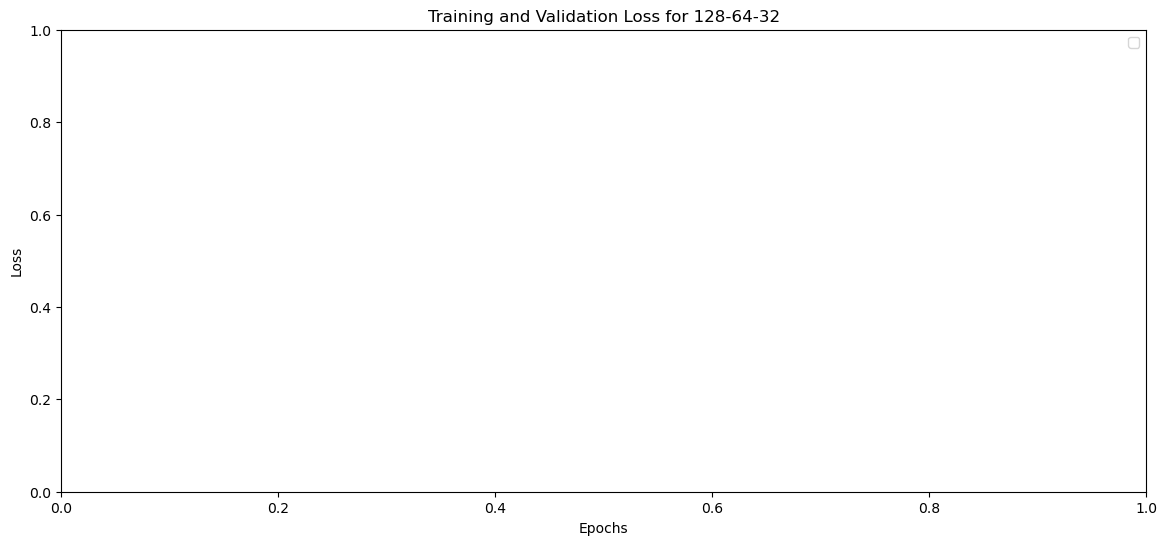

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


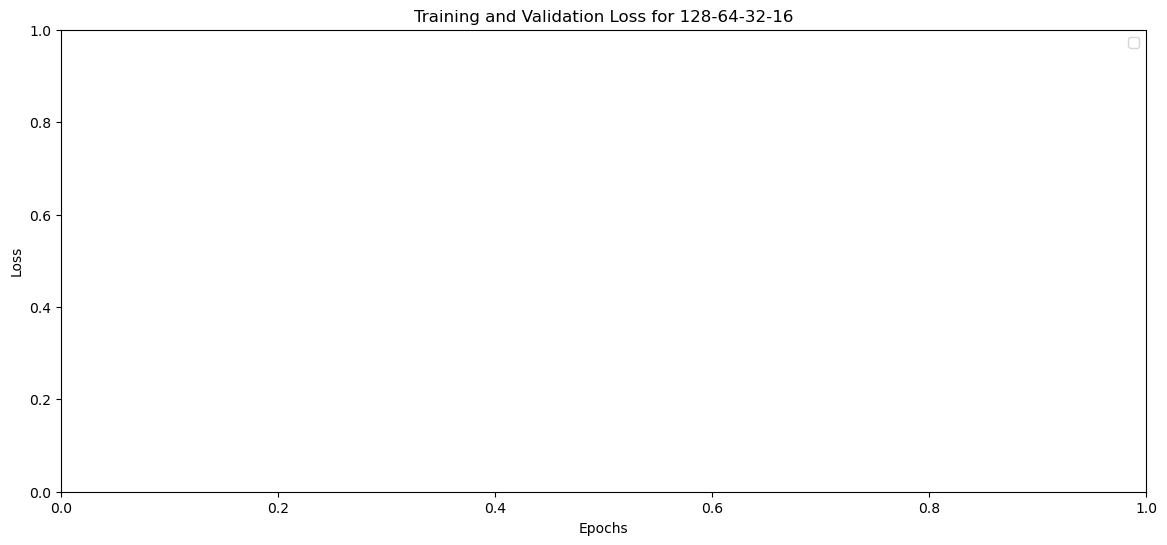

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


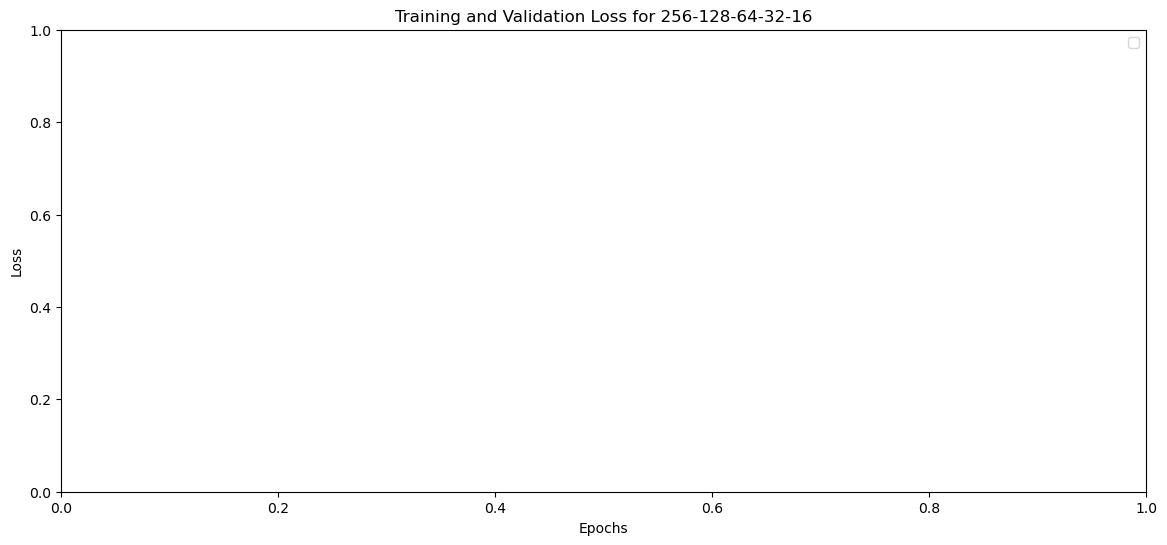

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


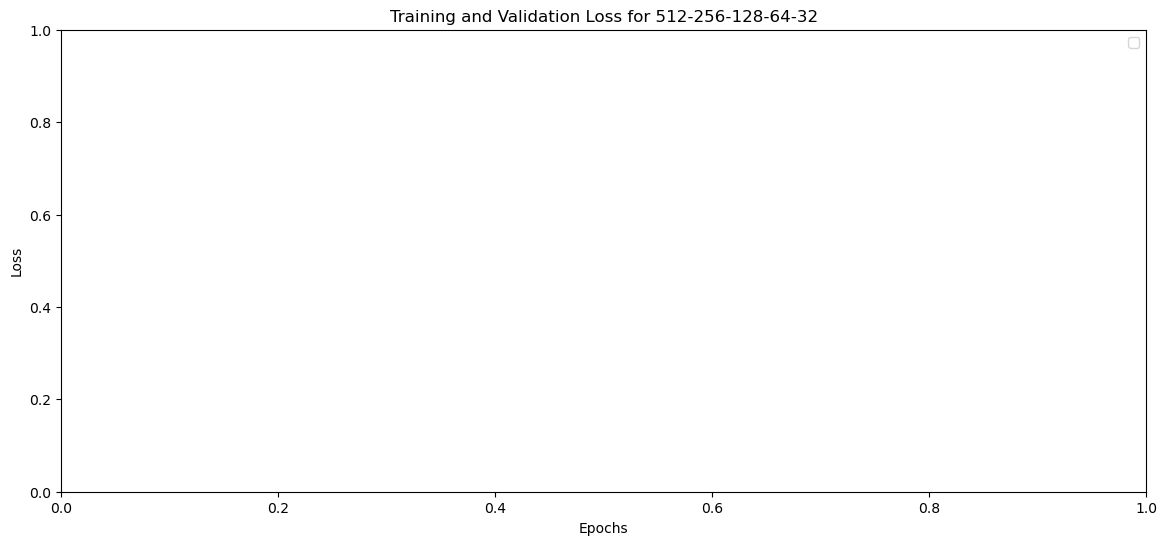

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


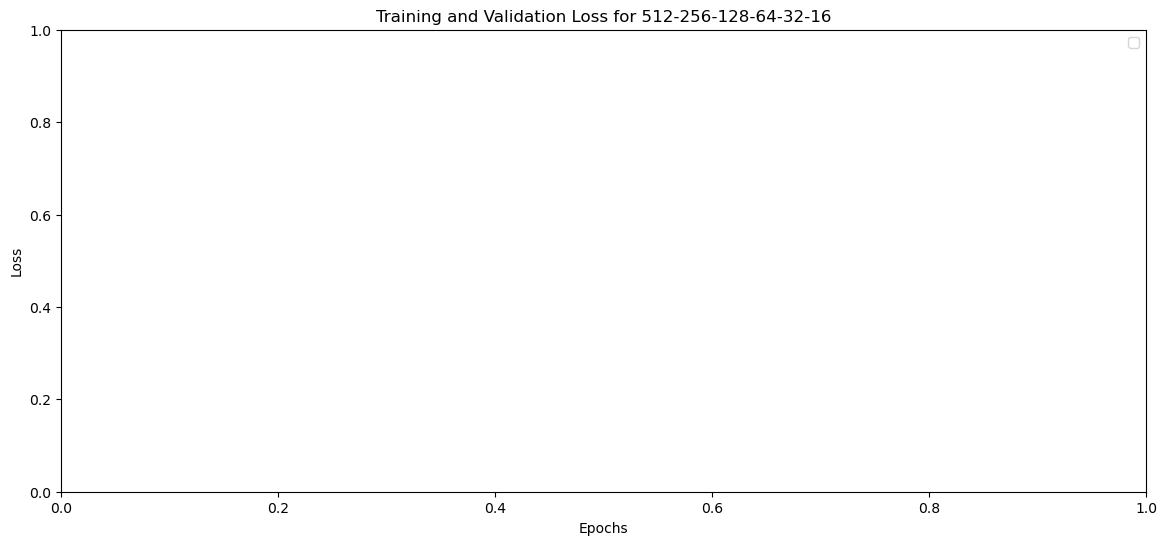

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

# Carregar o conjunto de dados
digits = load_digits()
X = digits.data
y = to_categorical(digits.target, 10)

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def build_mlp(input_dim, layers, output_dim, output_activation, regularizer=None):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, activation='relu'))
    for layer in layers[1:]:
        if regularizer:
            model.add(Dense(layer, activation='relu', kernel_regularizer=regularizer))
        else:
            model.add(Dense(layer, activation='relu'))
    model.add(Dense(output_dim, activation=output_activation))
    return model

# Definição das topologias e dicionários para armazenar os resultados e históricos
topologies = [
    [32, 16],
    [64, 32, 16],
    [128, 64, 32],
    [128, 64, 32, 16],
    [256, 128, 64, 32, 16],
    [512, 256, 128, 64, 32],
    [512, 256, 128, 64, 32, 16]
]
results = {}
histories = {}


#Barra de progresso com a lib tqdm
for layers in tqdm(topologies, desc="Training models", unit="topology"):
    topology_key = '-'.join(map(str, layers))
    results[topology_key] = {}
    histories[topology_key] = {}
    
    # 1. Modelo sem momentum e sem regularização
    model = build_model(input_dim, layers, output_dim, output_activation)
    model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
    model.save(f"model_{topology_key}_no_momentum_no_regularization.keras")
    
    # 2. Modelo com momentum
    model_momentum = build_model(input_dim, layers, output_dim, output_activation)
    optimizer_momentum = SGD(momentum=0.9)
    model_momentum.compile(optimizer=optimizer_momentum, loss='categorical_crossentropy', metrics=['accuracy'])
    model_momentum.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
    model_momentum.save(f"model_{topology_key}_momentum.keras")
    
    # 3. Modelo com regularização L2
    model_l2 = build_model(input_dim, layers, output_dim, output_activation, regularizer=l2(l2_lambda))
    model_l2.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    model_l2.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
    model_l2.save(f"model_{topology_key}_l2.keras")
    
    # 4. Modelo com regularização L2 e momentum
    model_l2_momentum = build_model(input_dim, layers, output_dim, output_activation, regularizer=l2(l2_lambda))
    optimizer_l2_momentum = SGD(momentum=0.9)
    model_l2_momentum.compile(optimizer=optimizer_l2_momentum, loss='categorical_crossentropy', metrics=['accuracy'])
    model_l2_momentum.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, verbose=0)
    model_l2_momentum.save(f"model_{topology_key}_l2_momentum.keras")





